In [6]:
from helper_functions import *
import numpy as np
from scipy.stats import ortho_group
from SPM import subspace_power_method
from scipy.optimize import minimize, fmin_slsqp
import pandas as pd
from ICA_code import cumulant_tensors
import matplotlib.pyplot as plt
import h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
from sklearn.metrics import silhouette_score
from pcpca import PCPCA
from contrastive import CPCA
from os.path import join as pjoin
from scipy.io import mmread
from sklearn.decomposition import PCA
import torch
from cICA_functions_old import *
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

In [7]:
import tikzplotlib
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [8]:
from numpy.linalg import slogdet
inv = np.linalg.inv
def make_L(X):
        p = X.shape[0]
        unobserved_idx = np.where(np.isnan(X))[0]
        observed_idx = np.setdiff1d(np.arange(p), unobserved_idx)
        L = np.zeros((observed_idx.shape[0], p))
        for ii, idx in enumerate(observed_idx):
            L[ii, idx] = 1
        return L

def log_likelihood_fg(X, W, sigma2):
    p, n = X.shape
    Ls = [make_L(X[:, ii]) for ii in range(n)]

    As = [Ls[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ls[ii].T for ii in range(n)]

    running_sum_X = 0
    for ii in range(n):
        L = Ls[ii]
        A = As[ii]
        x = L @ np.nan_to_num(X[:, ii], nan=0)
        Di = L.shape[0]
        A_inv = inv(A)

        curr_summand = (
            Di * np.log(2 * np.pi) + slogdet(A)[1] + np.trace(A_inv @ np.outer(x, x))
        )
        running_sum_X += curr_summand

    LL = -0.5 * running_sum_X

    return LL

In [9]:
from sklearn.metrics import adjusted_rand_score as ARC
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import normalized_mutual_info_score as NMI

def Kmeans_based_score(X,direction,label):
    kmeans=KMeans(n_clusters=2,init='k-means++')
    predicted_label=kmeans.fit_predict(X@direction)
    return ARC(label,predicted_label),NMI(label,predicted_label)

def SVC_based_score(X,direction,label):
    clf=SVC(kernel='linear')
    clf.fit(X@direction,label)
    predicted_label=clf.predict(X@direction)
    return ARC(label,predicted_label),NMI(label,predicted_label)

## Mice protein data

In [10]:
# adapt the original function to also output lambda and lambda'
def recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=None,r=None,l=None):
    I=k4_b.shape[0]
    if r==None:
        # get flattening of k4_b
        matK4b=k4_b.reshape(I**2,I**2)
        # remove repeat entries from matK
        symind, findsym, symindscale = symmetric_indices(I, 2)
        symindscale = np.sqrt(symindscale)
        findsym = findsym.flatten()
        symind = symind[::-1,:].T @ (I ** np.arange(2))
        sym_matK4b = symindscale.reshape(1, -1) * matK4b[symind][:, symind] * symindscale.reshape(-1, 1)
        D_prime,symV_prime=eig2(sym_matK4b)
        eigtol= 1e-12
        rank_k4_b=D_prime.shape[0]-np.searchsorted(abs(D_prime[::-1]), eigtol)
        # r=min(rank_k4_b,I)
        r=rank_k4_b
    
    # recover the a_i vectors (backgroud patterns) & prevent repetitive vectors
    a_s,lambdas=subspace_power_method(k4_b,n=4,d=I,r=r)
    first_residule=return_residual(k4_b,a_s,lambdas)/(I**4)
    def returnmindistancebewteenvectors(cols):
        def distancebewteenvectors(v1,v2):
            v1=v1.reshape(-1,1)
            v2=v2.reshape(-1,1)
            M=v1@np.transpose(v1)-v2@np.transpose(v2)
            return np.sum(M*M)
        lens=cols.shape[1]
        error=1
        for i in range(lens):
            for j in range(i+1,lens):
                error=min(error,max(distancebewteenvectors(cols[:,i],cols[:,j]),distancebewteenvectors(cols[:,i],-cols[:,j])))
        return error
    step=0
    if step_max==None:
        step_max=100
    while returnmindistancebewteenvectors(a_s)<0.1 and step<step_max:
        a_s,lambdas=subspace_power_method(k4_b,n=4,d=I,r=r)
        step+=1
    # print('step',step)
    
    # get flattening of k4_f,k4_b
    k4_f_copy=k4_f.copy()
    matK4f=k4_f_copy.reshape(I**2,I**2)

    # remove repeat entries from matK
    symind, findsym, symindscale = symmetric_indices(I, 2)
    symindscale = np.sqrt(symindscale)
    findsym = findsym.flatten()
    symind = symind[::-1,:].T @ (I ** np.arange(2))
    sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
    D, symV = eig2(sym_matK4f)
    eigtol= 1e-12
    rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
    D = D[:rank_k4_f]
    V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
    D1 = np.diagflat(1. / D).T
    # learn coefficients of a_i in k4_f
    lambda_prime=[]
    for a in a_s.T:
        apow = khatri_rao_power(a.reshape(-1, 1), 2)
        alpha = (apow.T @ V).T
        D1alpha = D1 @ alpha
        scalar=(alpha.T @ D1alpha)[0,0]
        k4_f_copy-=(1. / scalar)*generate_lowrank_tensor(a.reshape(-1,1),4)
        lambda_prime.append(1./scalar)
        matK4f=k4_f_copy.reshape(I**2,I**2)
        sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
        D, symV = eig2(sym_matK4f)
        eigtol= 1e-12
        rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
        D = D[:rank_k4_f]
        V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
        D1 = np.diagflat(1. / D).T
    if l==None:
        l=rank_k4_f
        print('l',l)
    
    Diag,B=eig2(k4_f_copy.reshape(I**2,I**2))
    D_foreground=Diag
    M=k4_f_copy.reshape(I**2,I**2)
    blist=[]
    eigen_list = []
    for n,bpow in enumerate(B.T[:l]):
        bpowmat=bpow.reshape(I,I)
        Diag_prime,eigen=eig2(bpowmat)
        b=eigen[:,0].flatten()
        eigen_list.append(Diag_prime[0])
        blist.append(b/np.sum(b*b)**0.5)
        bpow=Diag_prime[0]*khatri_rao_power(b.reshape(-1, 1), 2)
        M-=Diag[n]*bpowmat.reshape(-1,1)@bpowmat.reshape(1,-1)
    # coefficients for b_i
    print((np.array(eigen_list)**2)*Diag[:l])
    blist=np.array(blist).T
    second_residule=np.sum(M*M)/(I**4)
    # rank b_i according to their variance ratio
    contrastvarlist=[]
    fore_varlist=[]
    back_varlist=[]
    for b in blist.T:
        b=b.reshape(-1,1)
        fore_var=(b.T@ k2_f @ b).flatten()
        back_var=(b.T@k2_b @ b).flatten()
        # varlist.append(fore_var)
        contrastvarlist.append(fore_var/back_var)
        fore_varlist.append(fore_var)
        back_varlist.append(back_var)

    contrastind=(-np.array(contrastvarlist)).flatten().argsort().tolist()
    b_s_sorted_contrast= blist[:,contrastind]
    return a_s,b_s_sorted_contrast,np.array(contrastvarlist).flatten()[contrastind],first_residule,second_residule,D_foreground,lambda_prime,lambdas


In [11]:
# mouse data

# Read in data
data = pd.read_excel('mouse_data/Data_Cortex_Nuclear.xlsx')

# Separate into background and foreground data
# In this case,
# background data is data from mice who did not receive shock therapty
# foreground data is from mice who did receive shock therapy


# Get names of proteins
protein_names = data.columns.values[1:78]

# Fill NAs
data = data.fillna(0)

# Background
Y_df = data[
    (data.Behavior == "C/S")
    & (data.Genotype == "Control")
    & (data.Treatment == "Saline")
]
Y = Y_df[protein_names].values
Y -= np.nanmean(Y, axis=0)
Y /= np.nanstd(Y, axis=0)



# Foreground
X_df = data[(data.Behavior == "S/C") & (data.Treatment == "Saline")]
X = X_df[protein_names].values
mean=np.nanmean(X, axis=0)
std=np.nanstd(X, axis=0)
X -= mean
X /= std

Z_1df=data[
    (data.Behavior == "S/C")
    & (data.Genotype == "Control")& (data.Treatment == "Saline")]
Z1 = Z_1df[protein_names].values
Z1 -= mean
Z1 /= std

Z_2df=data[
    (data.Behavior == "S/C")
    & (data.Genotype != "Control")& (data.Treatment == "Saline")]
Z2 = Z_2df[protein_names].values
Z2 -= mean
Z2 /= std

n,I = X.shape
m,_ = Y.shape
X=np.vstack((Z1,Z2))

from sklearn.decomposition import PCA

# 15 components explain 90% covariance
pca=PCA(n_components=15)
Y_pca=pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))

Y_pca=pca.transform(Y)
Z1_pca=pca.transform(Z1)
Z2_pca=pca.transform(Z2)
X_pca=np.vstack((Z1_pca,Z2_pca))
# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
k4_f=np.load('mouse_data/k4_f.npy')
k4_b=np.load('mouse_data/k4_b.npy')
k2_f=np.load('mouse_data/k2_f.npy')
k2_b=np.load('mouse_data/k2_b.npy')

label=np.hstack((np.zeros(Z1_pca.shape[0]),np.ones(Z2_pca.shape[0])))

[0.33875351 0.47301379 0.55444589 0.61736511 0.67233563 0.71487014
 0.75152446 0.78286761 0.80981964 0.8333142  0.84963109 0.86411082
 0.87609972 0.88651199 0.89588937]


/Users/kexinwang/micromamba/envs/cs109a/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [12]:
def mice_silhouette(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@Z1_pca.T,pattern_2@Z1_pca.T))
    cluster_2=np.vstack((pattern_1@Z2_pca.T,pattern_2@Z2_pca.T))
    label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,label)

def plot_graph_mice(directions,xlabel,ylabel,title,sil_score,name):
    fix,axs=plt.subplots(1,1,figsize=(6,8))
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    axs.scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,label='background')
    axs.scatter(pattern_1@Z1_pca.T,pattern_2@Z1_pca.T,label='Down symdrome')
    axs.scatter(pattern_1@Z2_pca.T,pattern_2@Z2_pca.T,label='no Down symdrome')
    axs.legend(frameon=False)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fix)
    # tikzplotlib.save(name+".tex")

def mice_silhouette_whole_dataset(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@Z1.T,pattern_2@Z1.T))
    cluster_2=np.vstack((pattern_1@Z2.T,pattern_2@Z2.T))
    label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,label)

def plot_graph_mice_wholedataset(directions,xlabel,ylabel,title,sil_score,name):
    fix,axs=plt.subplots(1,1,figsize=(6,8))
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    axs.scatter(pattern_1@Y.T,pattern_2@Y.T,label='background')
    axs.scatter(pattern_1@Z1.T,pattern_2@Z1.T,label='Down symdrome')
    axs.scatter(pattern_1@Z2.T,pattern_2@Z2.T,label='no Down symdrome')
    axs.legend(frameon=False)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fix)
    # tikzplotlib.save(name+".tex")


Text(0.5, 1.0, 'PCA on X silhouette score:0.063')

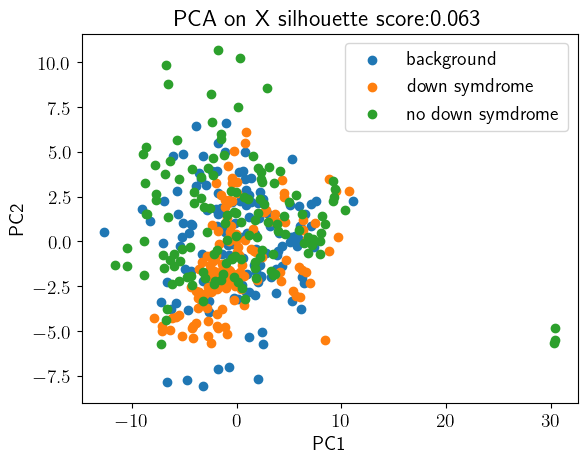

In [13]:
# PCA on foreground does not work
label=np.vstack((np.zeros(Z1.shape[0]),np.ones(Z2.shape[0]))).reshape(-1)
pca=PCA(n_components=2)
X_top2=pca.fit_transform(X)
fig,axs=plt.subplots(1,1)
directions=pca.components_.T
pattern_1=directions[:,0].reshape(1,-1)
pattern_2=directions[:,1].reshape(1,-1)
axs.scatter(pattern_1@Y.T,pattern_2@Y.T,label='background')
axs.scatter(pattern_1@Z1.T,pattern_2@Z1.T,label='down symdrome')
axs.scatter(pattern_1@Z2.T,pattern_2@Z2.T,label='no down symdrome')
axs.legend()
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
sil_score=silhouette_score(X_top2,label)
axs.set_title('PCA on X'+' '+'silhouette score:'+f'{sil_score:0.3f}')

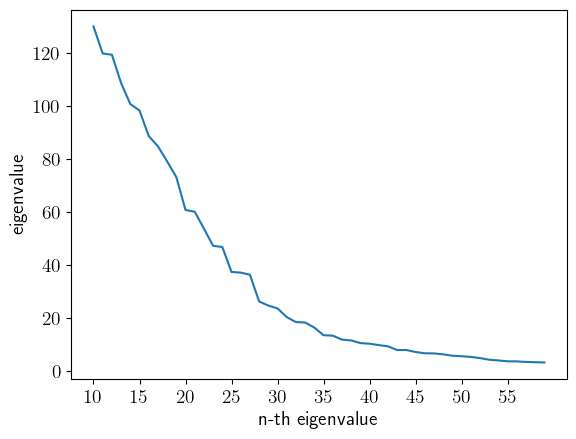

In [14]:
#cICA choices of r=27
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))

plt.plot(range(10,60),abs(D)[10:60])
plt.xticks(range(10,60,5))
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')

tikzplotlib.save("mouse_r.tex")

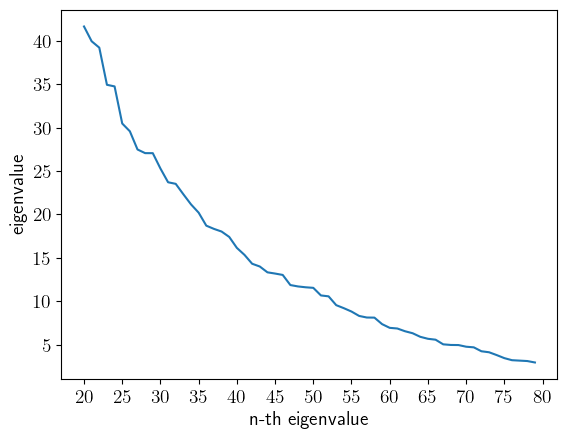

In [15]:
#cICA choices of r+\ell=53
I=k4_f.shape[0]
D,V=eig2(k4_f.reshape(I**2,I**2))
plt.plot(range(20,80),abs(D)[20:80])
plt.xticks(range(20,81,5))
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
tikzplotlib.save("mouse_r_l.tex")

In [16]:
#cICA r=27 l=26 analyse 
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residule,D_foreground,lambda_prime,lambdas=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=27,l=26)

[ 1.08454502e+04 -2.28568984e+02  2.71361784e+02 -1.54857575e+02
  1.96382470e+02 -9.44897354e+01 -7.33497332e+01 -1.17334063e+02
 -5.04431982e+01  8.29535684e+01  5.34440220e+01 -4.13679058e+01
 -4.04767256e+01  3.95639825e+01 -4.26764780e+01 -2.60786111e+01
  1.59294887e+01 -3.31269176e+01 -1.66577923e+01  2.67769595e+01
 -1.40827136e+01 -1.51419727e+01  2.47189096e+01 -1.20607655e+01
 -1.05139206e+01  1.13929555e+01]


In [17]:
np.mean(abs(np.array(lambda_prime)))

6.838746406683199

In [18]:
cumulant_ratio = abs(np.array(lambda_prime)/lambdas)
cumulant_ratio.max(),cumulant_ratio.min(),lambda_prime,cumulant_ratio

(0.12139744503873916,
 0.00012782696665056145,
 [-0.669324178266502,
  -3.9451644999211464,
  -5.865509612992984,
  -3.474144165510286,
  -1.2762230812705835,
  -59.57708383962698,
  -0.3964250425527318,
  0.05077643294625528,
  -0.07979010191760535,
  0.07081733773275818,
  0.10979582108406634,
  -1.582906554636074,
  3.170603753001615,
  -0.310348327131829,
  -5.567470872992259,
  -22.69204355612783,
  -0.7104681772502972,
  0.9099662465747732,
  1.4867223339981743,
  35.07365821733162,
  30.589371824236874,
  -0.7380092839172984,
  -0.08586433880647565,
  -2.416812509783423,
  0.7855391456068495,
  1.4776379731853058,
  1.533675752043768],
 array([0.00105272, 0.00620501, 0.00744552, 0.00579092, 0.00398096,
        0.12139745, 0.00069663, 0.00012783, 0.00022494, 0.00014719,
        0.00034346, 0.00290647, 0.00571496, 0.00143813, 0.01239346,
        0.1101623 , 0.00368193, 0.00228356, 0.00462338, 0.10394953,
        0.0743519 , 0.0044344 , 0.00055605, 0.01521817, 0.0041332 ,
        0

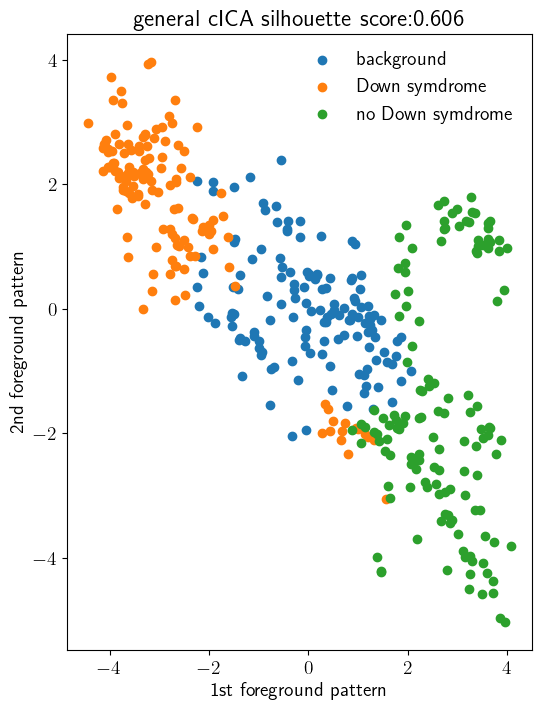

In [19]:
#cICA r=27 l=26 plot
plot_graph_mice(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern','general cICA',mice_silhouette(b_s_sorted[:,:2]),"mouse_cICA")
# np.save('mice_b',b_s_sorted)

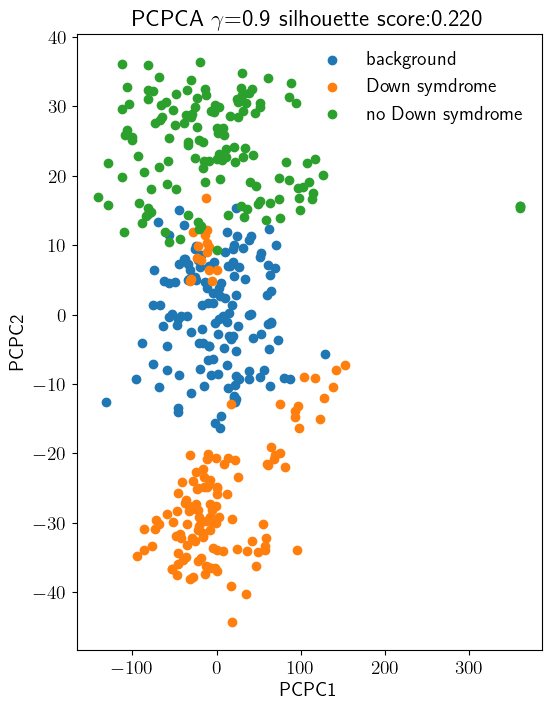

In [20]:
#PCPCA on whole datasets choose gamma
silhouette_score_list=[]
b_list=[]
n, m = X.shape[0], Y.shape[0]
for gamma in np.linspace(0,0.9,100):
    pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
    X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
    b=pcpca.W_mle
    # b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
    silhouette_score_list.append(mice_silhouette_whole_dataset(b))
    b_list.append(b)
index=np.argmax(np.array(silhouette_score_list))
gamma=np.linspace(0,0.9,100)[index]
plot_graph_mice_wholedataset(b_list[index],'PCPC1','PCPC2',f'PCPCA $\gamma$={gamma}',silhouette_score_list[index],"mouse_PCPCA")
directions=b_list[index]


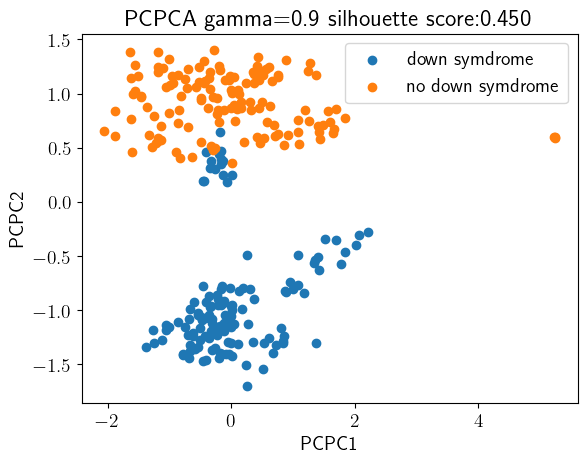

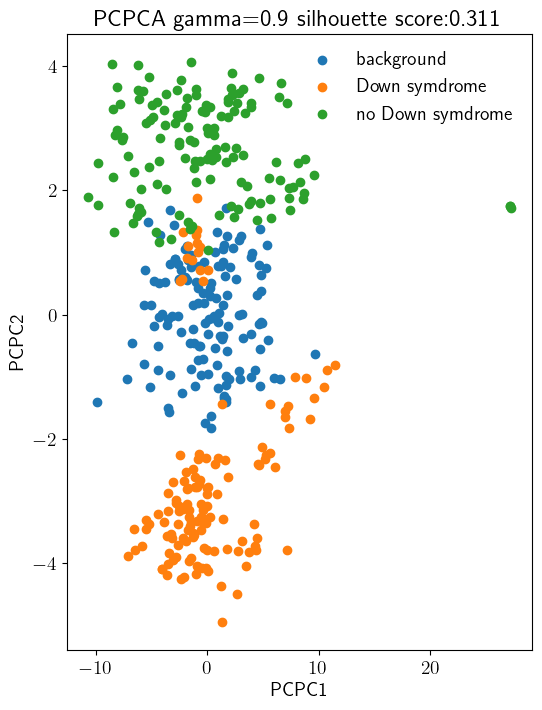

In [22]:
#PCPCA whole dataset with gamma = 0.9
# normlize X,Y
gamma=0.9
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
X_reduced = (X_reduced.T / X_reduced.T.std(0)).T
# Y_reduced = (Y_reduced.T / X_reduced.T.std(0)).T
fig,axs=plt.subplots(1,1)
# axs.scatter(Y_reduced[0,:].T,Y_reduced[1,:].T,label='background')
axs.scatter(X_reduced[0,:135].T,X_reduced[1,:135].T,label='down symdrome')
axs.scatter(X_reduced[0,135:].T,X_reduced[1,135:].T,label='no down symdrome')
axs.legend()
axs.set_xlabel('PCPC1')
axs.set_ylabel('PCPC2')
sil_score=silhouette_score(X_reduced.T,label)
axs.set_title('PCPCA'+f' gamma={gamma}'+' '+'silhouette score:'+f'{sil_score:0.3f}')

# normalize b
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
plot_graph_mice_wholedataset(b,'PCPC1','PCPC2',f'PCPCA gamma={gamma}',mice_silhouette_whole_dataset(b),"pcpca")


[  0.          26.56087783 298.36472403 628.02914418]


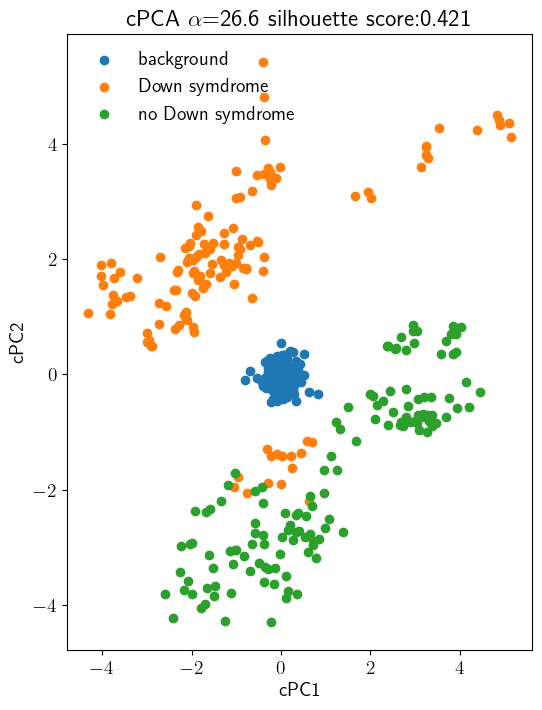

In [64]:
#CPCA whole dataset choose alpha
mdl=CPCA()
silhouette_score_list=[]
label=np.hstack((np.zeros(Z1.shape[0]),np.ones(Z2.shape[0])))
l,alphas=mdl.fit_transform(X,Y,active_labels=label,n_alphas=100,return_alphas=True,max_log_alpha=3)
print(alphas)
for array in l:
    silhouette_score_list.append(silhouette_score(array,label))
index=np.argmax(silhouette_score_list)
alpha=alphas[index]
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_mice_wholedataset(b_cpca,'cPC1','cPC2',f'cPCA $\\alpha $={alpha:0.1f}',mice_silhouette_whole_dataset(b_cpca),"mouse_cPCA")
directions=b_cpca

1e-06


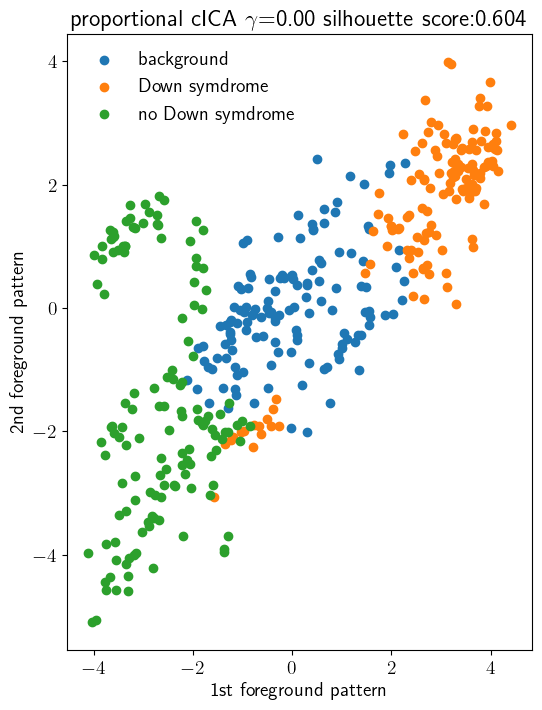

In [65]:
# hierachical tensor decomp of k4_f-gamma k4_b choose gamma
sil_score=[]
for gamma in np.logspace(-3,3,num=100): 
    gamma=gamma**2
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,26)
    sil_score.append(mice_silhouette(b_s_sorted[:,:2]))
index=np.argmax(np.array(sil_score))
gamma=((np.logspace(-3,3,num=100))[index])**2
print(gamma)
b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,26)
plot_graph_mice(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern',f'proportional cICA $\gamma$={gamma:0.2f}',mice_silhouette(b_s_sorted[:,:2]),"mouse_proportional_cICA")
directions=b_s_sorted[:,:2]

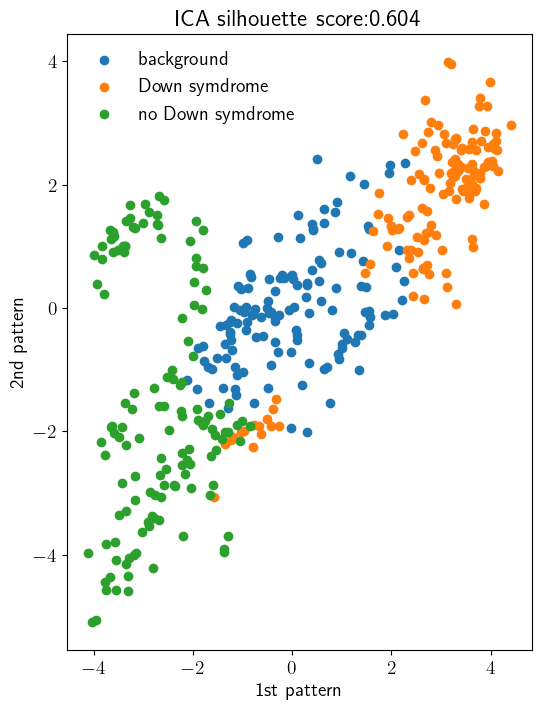

In [8]:
# ICA
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residule,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=0,l=26+27)
plot_graph_mice(b_s_sorted[:,:2],'1st pattern','2nd pattern','ICA',mice_silhouette(b_s_sorted[:,:2]),"mouse_ICA")


# Single-cell RNA data

In [83]:
# data downloaded from https://www.10xgenomics.com/datasets/frozen-bmm-cs-healthy-control-2-1-standard-1-1-0
fnames = ['293t',           #0
          'aml027_post',    #1
          'aml027_pre',     #2
          'aml035_post',    #3
          'aml035_pre',     #4
          'b',              #5
          'bmmc_healthy_1', #6
          'bmmc_healthy_2', #7
         ] 

DATA_DIR = 'single_cell_RNA_data_files/'
N_GENES = 500


def get_data_df(subdata_dir):
    data = mmread(pjoin(DATA_DIR, subdata_dir, "hg19/matrix.mtx")).toarray()
    data = np.log(data + 1)
    genes = pd.read_table(pjoin(DATA_DIR, subdata_dir, "hg19/genes.tsv"), header=None)
    barcodes = pd.read_table(
        pjoin(DATA_DIR, subdata_dir, "hg19/barcodes.tsv"), header=None
    )
    data_df = pd.DataFrame(
        data, index=genes.iloc[:, 0].values, columns=barcodes.iloc[:, 0].values
    )

    data_df = data_df.iloc[:, np.sum(data_df.values, axis=0) != 0]
    data_df = data_df.iloc[np.sum(data_df.values, axis=1) != 0, :]
    return data_df.transpose()


## Load all data
pretransplant1 = get_data_df("aml027_pre")
posttransplant1 = get_data_df("aml027_post")
pretransplant2 = get_data_df("aml035_pre")
posttransplant2 = get_data_df("aml035_post")

healthy1 = get_data_df("bmmc_healthy_1")
healthy2 = get_data_df("bmmc_healthy_2")

shared_genes = pretransplant1.columns.values
for curr_df in [posttransplant1, pretransplant2, posttransplant2, healthy1, healthy2]:
    shared_genes = np.intersect1d(shared_genes, curr_df.columns.values)

stacked_df = pretransplant1[shared_genes]
for curr_df in [
    posttransplant1,
    pretransplant2,
    posttransplant2,
]:  # , healthy1, healthy2]:
    stacked_df = pd.concat([stacked_df, curr_df[shared_genes]], axis=0)
print("Total of {} cells and {} genes".format(stacked_df.shape[0], stacked_df.shape[1]))

gene_means = np.mean(stacked_df.values, axis=0)
gene_vars = np.var(stacked_df.values, axis=0)
gene_dispersions = gene_vars / gene_means
top_idx = np.argsort(-gene_dispersions)[:N_GENES]
top_genes = stacked_df.columns.values[top_idx]

print("Saving {} genes".format(top_genes.shape[0]))

pretransplant1[top_genes].to_csv(pjoin(DATA_DIR, "clean", "pretransplant1.csv"))
posttransplant1[top_genes].to_csv(pjoin(DATA_DIR, "clean", "posttransplant1.csv"))

pretransplant2[top_genes].to_csv(pjoin(DATA_DIR, "clean", "pretransplant2.csv"))
posttransplant2[top_genes].to_csv(pjoin(DATA_DIR, "clean", "posttransplant2.csv"))

healthy1[top_genes].to_csv(pjoin(DATA_DIR, "clean", "healthy1.csv"))
healthy2[top_genes].to_csv(pjoin(DATA_DIR, "clean", "healthy2.csv"))

Total of 12399 cells and 12079 genes
Saving 500 genes


In [23]:
# Background is made up of healthy cells
DATA_DIR = 'single_cell_RNA_data_files/'
pretransplant2 = pd.read_csv(pjoin(DATA_DIR, "clean", "pretransplant2.csv"), index_col=0)
pretransplant1= pd.read_csv(pjoin(DATA_DIR, "clean", "pretransplant1.csv"), index_col=0)
posttransplant2 = pd.read_csv(pjoin(DATA_DIR, "clean", "posttransplant2.csv"), index_col=0)
posttransplant1=pd.read_csv(pjoin(DATA_DIR, "clean", "posttransplant1.csv"), index_col=0)

healthy1 = pd.read_csv(pjoin(DATA_DIR, "clean", "healthy1.csv"), index_col=0)
healthy2= pd.read_csv(pjoin(DATA_DIR, "clean", "healthy2.csv"), index_col=0)
Y = pd.concat([healthy1, healthy2], axis=0).values

X = pd.concat([pretransplant2,pretransplant1, posttransplant2,posttransplant1], axis=0).values
X_pre= pd.concat([pretransplant2, pretransplant1], axis=0).values
X_post= pd.concat([posttransplant2,posttransplant1], axis=0).values

# Standardize
Y -= Y.mean(0)
Y /= Y.std(0)
a=X.mean(0)
b=X.std(0)
X -= a
X /= b
X_pre-=a
X_pre/=b
X_post-=a
X_post/=b

n, m = X.shape[1], Y.shape[1]

pca=PCA(n_components=30)
pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))

X_pca_pre=pca.transform(X_pre)
X_pca_post=pca.transform(X_post)
Y_pca=pca.transform(Y)
X_pca=pca.transform(X)
X_pca=np.vstack((X_pca_pre,X_pca_post))

label=np.hstack((np.zeros(X_pca_pre.shape[0]),np.ones(X_pca_post.shape[0])))

# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
k2_b=np.load('single_cell_RNA_data_files/k2_b.npy')
k2_f=np.load('single_cell_RNA_data_files/k2_f.npy')
k4_b=np.load('single_cell_RNA_data_files/k4_b.npy')
k4_f=np.load('single_cell_RNA_data_files/k4_f.npy')

def RNA_silhouette(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_pca_pre.T,pattern_2@X_pca_pre.T))
    cluster_2=np.vstack((pattern_1@X_pca_post.T,pattern_2@X_pca_post.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)



def RNA_silhouette_wholedataset(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_pre.T,pattern_2@X_pre.T))
    cluster_2=np.vstack((pattern_1@X_post.T,pattern_2@X_post.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)



[0.19160671 0.29613218 0.33393818 0.36200888 0.38282322 0.40232312
 0.41945093 0.43330493 0.44555631 0.45596845 0.46459935 0.47239533
 0.47941659 0.48571725 0.49194181 0.49715359 0.50222033 0.50705599
 0.51157835 0.51589732 0.5200638  0.5240231  0.5275473  0.53105107
 0.5344759  0.53785362 0.54105059 0.5441597  0.54708453 0.54986927]


In [24]:
def plot_graph_RNA(directions,xlabel,ylabel,title,sil_score
                   ,name
                   ):
    fig,axs=plt.subplots(1,1,figsize=(6,8))
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pca_post.T,pattern_2@X_pca_post.T,label='post-transplant',s=0.8)
    axs.scatter(pattern_1@X_pca_pre.T,pattern_2@X_pca_pre.T,label='pre-transplant',s=0.8)
    
    axs.legend(frameon=False)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")
   



def plot_graph_RNA_2(directions,xlabel,ylabel,title,sil_score
                     ,name
                     ):
    fig,axs=plt.subplots(1,1,figsize=(7,8))
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pca_pre.T,pattern_2@X_pca_pre.T,label='pre-transplant',s=0.8)
    axs.scatter(pattern_1@X_pca_post.T,pattern_2@X_pca_post.T,label='post-transplant',s=0.8)
    axs.legend(frameon=False)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")

def plot_graph_RNA_wholedataset(directions,xlabel,ylabel,title,sil_score
                                ,name
                                ):
    fig,axs=plt.subplots(1,1,figsize=(6,8))
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_post.T,pattern_2@X_post.T,label='post-transplant',s=0.8)
    axs.scatter(pattern_1@X_pre.T,pattern_2@X_pre.T,label='pre-transplant',s=0.8)
    axs.legend(frameon=False)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")

def plot_graph_RNA_2_wholedataset(directions,xlabel,ylabel,title,sil_score
                                  ,name
                                  ):
    fig,axs=plt.subplots(1,1,figsize=(7,8))
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_pre.T,pattern_2@X_pre.T,label='pre-transplant',s=0.8)
    axs.scatter(pattern_1@X_post.T,pattern_2@X_post.T,label='post-transplant',s=0.8)
    axs.legend(frameon=False)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")

Text(0.5, 1.0, 'PCA on X silhouette score:0.107')

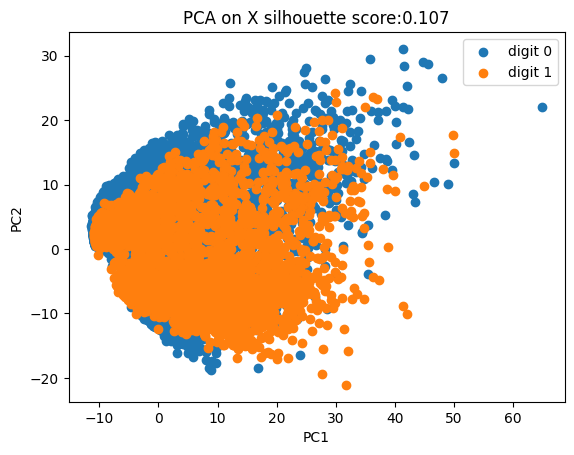

In [172]:
# PCA on foreground does not work
pca=PCA(n_components=2)
X_top2_RNA=pca.fit_transform(X)
fig,axs=plt.subplots(1,1)
directions=pca.components_.T
pattern_1=directions[:,0].reshape(1,-1)
pattern_2=directions[:,1].reshape(1,-1)

axs.scatter(pattern_1@X_pre.T,pattern_2@X_pre.T,label='digit 0')
axs.scatter(pattern_1@X_post.T,pattern_2@X_post.T,label='digit 1')
axs.legend()
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
sil_score=silhouette_score(X_top2_RNA,label)
axs.set_title('PCA on X'+' '+'silhouette score:'+f'{sil_score:0.3f}')

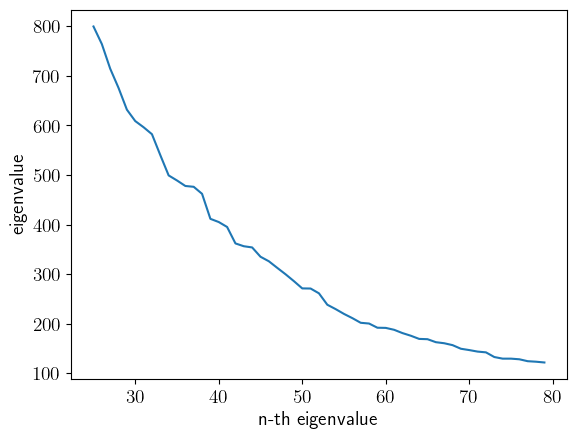

In [109]:
#cICA choices of r
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
# plt.plot(range(200),abs(D)[:200])
# plt.xlabel('n-th eigenvalue')
# plt.ylabel('eigenvalue')
# plt.figure()
plt.plot(range(25,80),abs(D)[25:80])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
tikzplotlib.save("RNA_r.tex")

#50-55 seems to be a reasonable choice

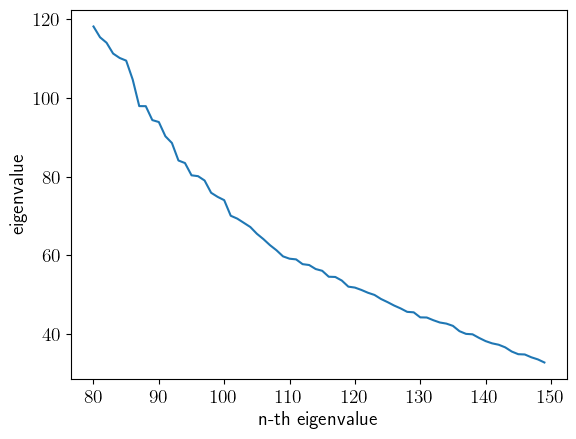

In [111]:
#cICA choice of r+\ell
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
# plt.plot(range(200),abs(D)[:200])
# plt.xlabel('n-th eigenvalue')
# plt.ylabel('eigenvalue')
# plt.figure()
plt.plot(range(80,150),abs(D)[80:150])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
# plt.figure()
# plt.plot(range(100,160),abs(D)[100:160])
# plt.xlabel('n-th eigenvalue')
# plt.ylabel('eigenvalue')
tikzplotlib.save("RNA_r_l.tex")


In [25]:
#cICA 
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residua,D_foreground,lamda_prime,lambdas=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=53,l=53+63)

[-6.38797130e+05  7.41266784e+04  1.26222268e+04  4.70954560e+03
 -3.80340814e+03  1.77745084e+03  1.93409869e+03 -2.29104170e+03
  1.35506986e+03  2.93379299e+03  1.20776639e+03  1.03533814e+03
 -1.67241446e+03  1.69152138e+03  8.32476387e+02 -1.03153803e+03
  7.13257205e+02  4.58080148e+02 -8.71486607e+02  6.14136563e+02
  5.04473206e+02  4.75032739e+02 -7.12405956e+02  5.99339219e+02
 -5.65791399e+02  3.32843152e+02  3.75694476e+02 -6.41235935e+02
 -3.54488756e+02  4.53502730e+02  3.19164514e+02  2.34082320e+02
  2.08253604e+02 -2.83378775e+02  2.25757989e+02 -3.19852146e+02
 -2.50264652e+02 -2.07450118e+02  1.47322145e+02  3.47940029e+02
  1.26160965e+02  1.02228602e+02 -1.75292437e+02  8.58925213e+01
  1.13380092e+02 -1.55250424e+02 -1.26892058e+02 -1.16885809e+02
 -1.28851472e+02  1.34314789e+02 -9.40060591e+01  8.36661950e+01
 -7.80855298e+01 -1.00529634e+02  6.17612691e+01  7.94701772e+01
 -7.09083115e+01 -8.35238223e+01  5.35478386e+01 -7.02442483e+01
  5.89842367e+01 -7.85179

In [26]:
cumulant_ratio = abs(np.array(lamda_prime)/lambdas)
cumulant_ratio.max(),cumulant_ratio.min(),lamda_prime,cumulant_ratio

(563.972048664206,
 0.00015342157244305947,
 [-3492.5766222602083,
  -18980.88866263121,
  -3995.590172220015,
  -13001.555423355294,
  10629.086035358929,
  7334.549430969158,
  -8366.468492382084,
  1627.6565759616233,
  -1878.6775646955234,
  -282.74083612306134,
  -64.54571248314603,
  6664.202516571188,
  -133.0451416322397,
  1834.7884519697968,
  -12432.362414027177,
  16708.99213545482,
  1458.9388865952815,
  410.1402183706457,
  -2043.0212703849907,
  401.96232812818914,
  -104.73073327635308,
  381.5628514797808,
  -42.85998937494753,
  120.75226891507417,
  305.7977270191641,
  1075.7817129437842,
  -1.0827080211962017,
  256.5604629961962,
  -43.59836757707586,
  -498.94342536162355,
  -25817.273838778267,
  -51.99026367268607,
  -9.436547001852531,
  -2730.869689129231,
  189.13942458339324,
  -8448.033504344832,
  -406.13634693429174,
  641397.1575562649,
  32.146789167743094,
  5238.077668977455,
  -43.04996132617293,
  -49.247731949232374,
  3271.187941870143,
  -717.1

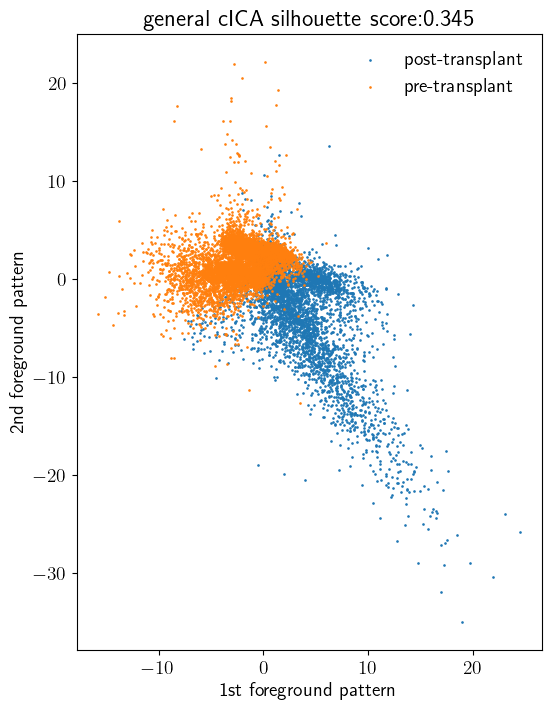

In [27]:
#cICA r=53 l=63 plot
plot_graph_RNA(b_s_sorted[:,[0,1]],'1st foreground pattern','2nd foreground pattern','general cICA',RNA_silhouette(b_s_sorted[:,[0,1]]),"name")

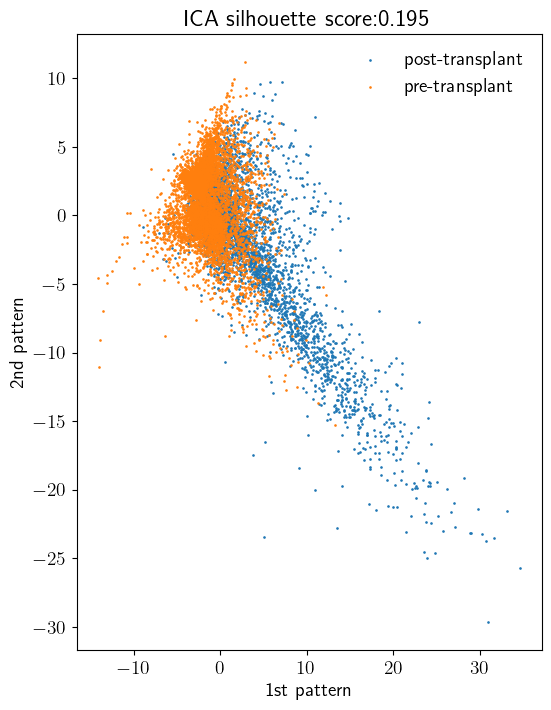

In [115]:
#ICA r=53+63 does not work
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residua,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=0,l=53+63)
plot_graph_RNA(b_s_sorted[:,[0,1]],'1st pattern','2nd pattern','ICA',RNA_silhouette(b_s_sorted[:,[0,1]]),"RNA_ICA")
# plot_graph_RNA_2(b_s_sorted[:,[0,1]],'1st pattern','2nd pattern','ICA',RNA_silhouette(b_s_sorted[:,[0,1]]))

In [13]:
sil_score = []
for a in a_s.T:
    a = a - np.sum(a*b_s_sorted[:,0])*b_s_sorted[:,0]
    a = a/np.linalg.norm(a)
    pattern = np.vstack((a,b_s_sorted[:,0])).T
    sil_score.append(RNA_silhouette(pattern))
a = a_s[:,np.argmax(sil_score)]
np.argmax(sil_score),max(sil_score)

(13, 0.3211307584689059)

In [14]:
sil_score = []
for a in a_s.T:
    a = a - np.sum(a*b_s_sorted[:,0])*b_s_sorted[:,0]
    a = a/np.linalg.norm(a)
    pattern = np.vstack((a,b_s_sorted[:,1])).T
    sil_score.append(RNA_silhouette(pattern))
a_prime = a_s[:,np.argmax(sil_score)]
np.argmax(sil_score),max(sil_score)

(13, 0.2667587926500941)

45


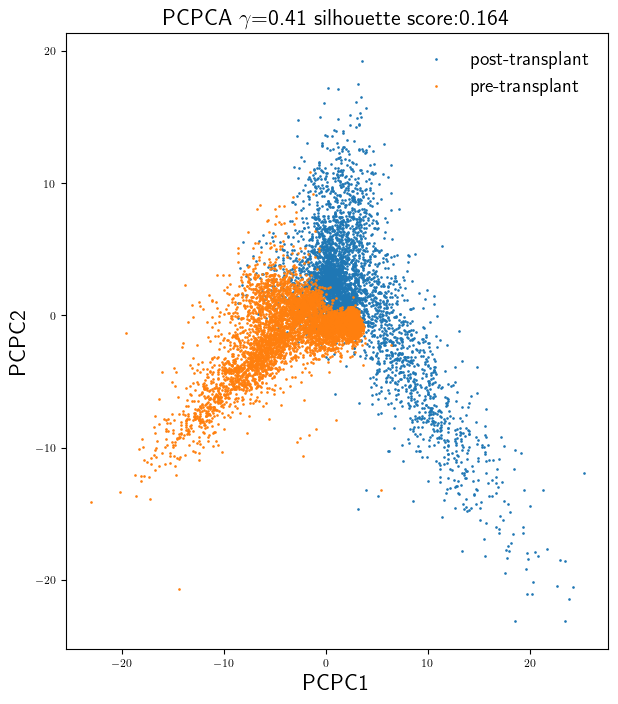

In [91]:
#PCPCA on whole dataset choose gamma
silhouette_score_list=[]
b_list=[]
n= X.shape[0]
m=Y.shape[0]
for gamma in np.linspace(0,0.9,100):
    pcpca = PCPCA(gamma=n/m*gamma, n_components=4)
    pcpca.fit(X.T,Y.T)
    b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
    silhouette_score_list.append(RNA_silhouette_wholedataset(b[:,[2,3]]))
    b_list.append(b)
index=np.argmax(np.array(silhouette_score_list))
gamma=np.linspace(0,0.9,100)[index]
print(index)
plot_graph_RNA_wholedataset(b_list[index][:,[2,3]],'PCPC1','PCPC2',f'PCPCA $\gamma$={gamma:0.2f}',silhouette_score_list[index])
directions=b_list[index]


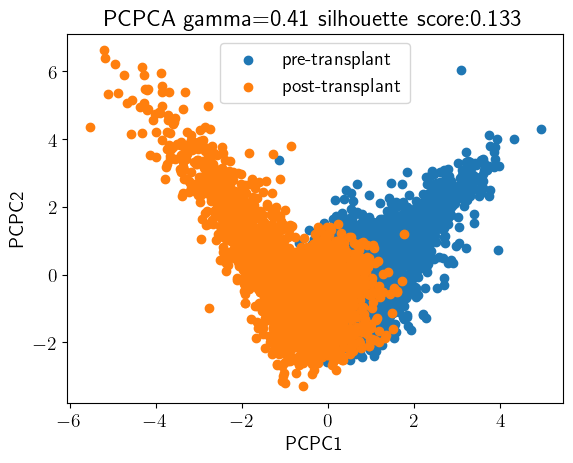

In [8]:
index=45
gamma=np.linspace(0,0.9,100)[index]

#PCPCA whole dataset
# normlize X,Y
pcpca = PCPCA(gamma=n/m*gamma, n_components=4)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
X_reduced = (X_reduced.T / X_reduced.T.std(0)).T
# Y_reduced = (Y_reduced.T / X_reduced.T.std(0)).T
fig,axs=plt.subplots(1,1)
# axs.scatter(Y_reduced[0,:].T,Y_reduced[1,:].T,label='background')
axs.scatter(X_reduced[2,:7525].T,X_reduced[3,:7525].T,label='pre-transplant')
axs.scatter(X_reduced[2,7525:].T,X_reduced[3,7525:].T,label='post-transplant')
axs.legend()
axs.set_xlabel('PCPC1')
axs.set_ylabel('PCPC2')
sil_score=silhouette_score(X_reduced[[2,3],:].T,label)
axs.set_title('PCPCA'+f' gamma={gamma:0.2f}'+' '+'silhouette score:'+f'{sil_score:0.3f}')
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("RNA_PCPCA.tex")

# normalize b
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=4)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
# plot_graph_RNA_wholedataset(b[:,[2,3]],'PCPC1','PCPC2',f'PCPCA gamma={gamma:0.2f}',RNA_silhouette_wholedataset(b),"delete")

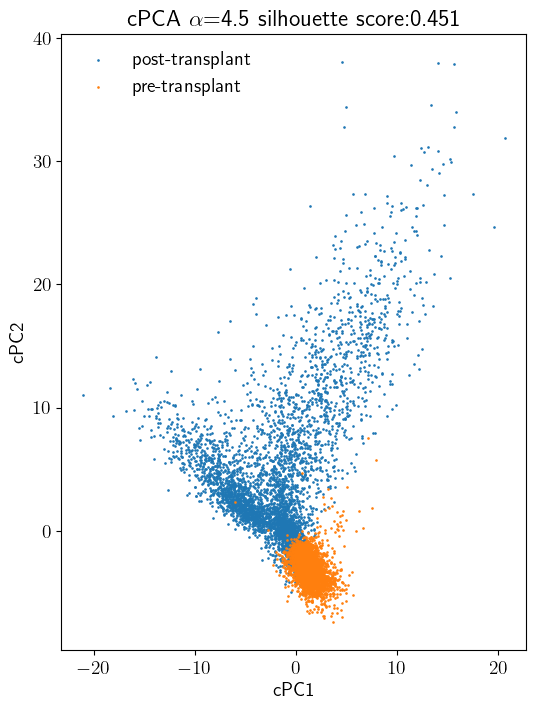

In [132]:
#CPCA whole dataset
mdl=CPCA()
silhouette_score_list=[]
l,alphas=mdl.fit_transform(X,Y,active_labels=label,n_alphas=100,return_alphas=True,max_log_alpha=3)
label=np.hstack((np.zeros(X_pre.shape[0]),np.ones(X_post.shape[0])))
for array in l:
    silhouette_score_list.append(silhouette_score(array,label))
index=np.argmax(np.array(silhouette_score_list))
alpha=alphas[index]
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_RNA_wholedataset(b_cpca,'cPC1','cPC2',f'cPCA $\\alpha$={alpha:0.1f}',silhouette_score_list[index],"RNA_cPCA")
directions=b_cpca


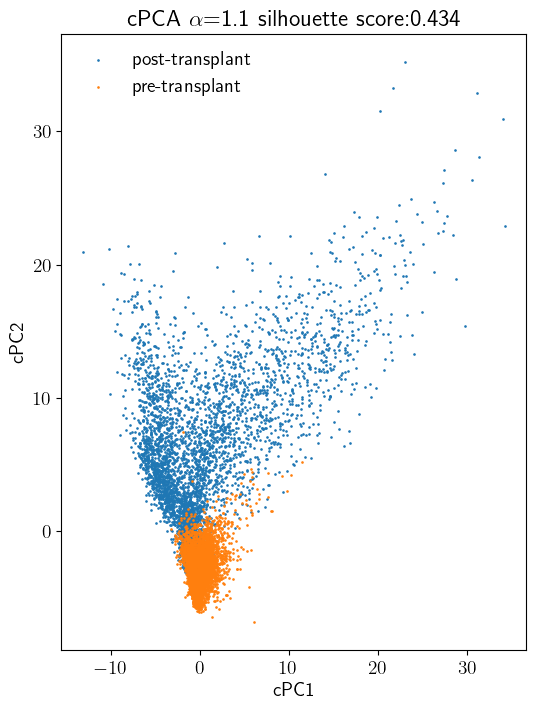

In [8]:
#cPCA PCA projected dataset
mdl=CPCA()
silhouette_score_list=[]
l,alphas=mdl.fit_transform(X_pca,Y_pca,active_labels=label,n_alphas=100,return_alphas=True,max_log_alpha=2)
label=np.hstack((np.zeros(X_pre.shape[0]),np.ones(X_post.shape[0])))
for array in l:
    silhouette_score_list.append(silhouette_score(array,label))
index=np.argmax(np.array(silhouette_score_list))
alpha=alphas[index]
D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_RNA(b_cpca,'cPC1','cPC2',f'cPCA $\\alpha$={alpha:0.1f}',silhouette_score_list[index],"RNA_cPCA_pca")
directions=b_cpca

47


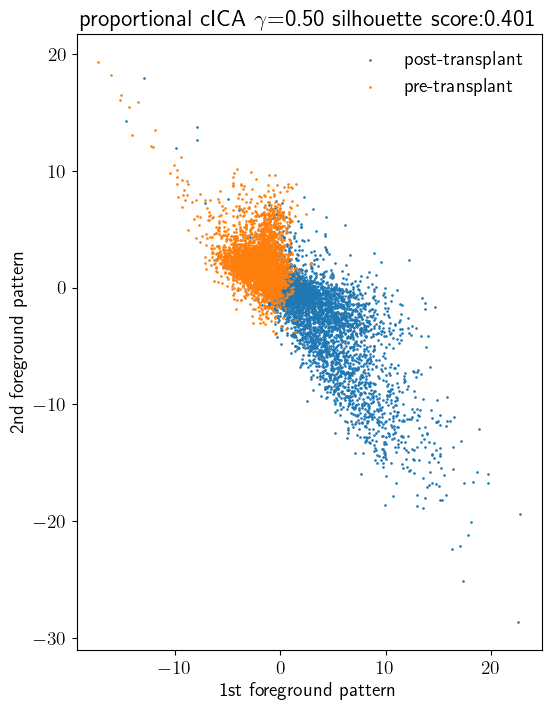

In [31]:
# hierachical tensor decomp of k4_f-gamma k4_b
sil_score=[]
for gamma in np.logspace(-3,3,num=100):
    gamma=gamma**2 
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,63)
    sil_score.append(RNA_silhouette(b_s_sorted[:,:2]))
index=np.argmax(np.array(sil_score))
gamma=(np.logspace(-3,3,num=100)[index])**2
print(index)
b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,63)
plot_graph_RNA(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern',f'proportional cICA $\gamma$={gamma:0.2f}',RNA_silhouette(b_s_sorted[:,:2]),"name")


In [29]:
def ratio(a):
    return np.linalg.norm(a@k2_f@a.T)/np.linalg.norm(a@k2_b@a.T)
ratio_list = []
for a in a_s.T:
    ratio_list.append(ratio(a))
np.argmax(ratio_list)

13

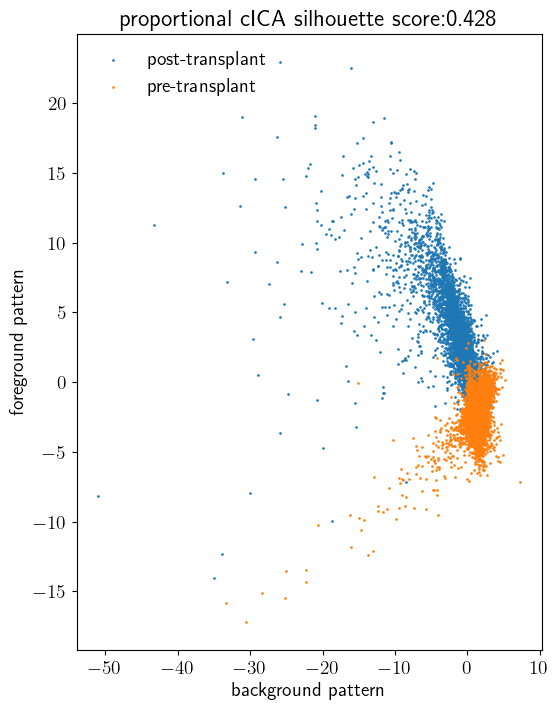

In [18]:
a= a_s[:,13]
a_projected = a - np.sum(a*b_s_sorted[:,0])*b_s_sorted[:,0]
a_projected = a_projected/np.linalg.norm(a_projected)
pattern = np.vstack((a_projected,b_s_sorted[:,0])).T
RNA_silhouette(pattern)
plot_graph_RNA(pattern,'background pattern','foreground pattern','proportional cICA',RNA_silhouette(pattern),"RNA_proportional_a_b")

# MNIST  discrete strength

In [32]:
from cICA_functions import *

In [ ]:
# background 50% grass, 50% cloud, foreground 80% grass, 20% cloud
# grass images are downloaded from imagenet with id n12102133
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index_0=np.where(y_train==0)[0]
index_1=np.where(y_train == 1)[0]
foreground=np.zeros(shape = (10000,28,28))
foreground[:2500,:,:]=X_train[index_0][:2500]
foreground[2500:5000,:,:]=X_train[index_1][:2500]
foreground[5000:7500,:,:]=X_train[index_0][2500:5000]+X_train[index_1][2500:5000]
foreground[5000:7500,:,:][foreground[5000:7500,:,:]>255]=255
# 0 means 0, 1 means 1, 
target_labels = np.sort(np.repeat([0, 1, 2, 3], 2500))


from PIL import Image
from resizeimage import resizeimage
import os

grass_IMAGE_PATH = 'n12102133/' #Replace with your own path to downloaded images
cloud_IMAGE_PATH = 'n09247410/' #Replace with your own path to downloaded images
        
grass_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
num=0
for filename in os.listdir(grass_IMAGE_PATH):
    num+=1
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(grass_IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale

            im = resizeimage.resize_crop(im,[100,100]) #resize and crop each picture to be 100px by 100px
            grass_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
            
grass_images=np.asarray(grass_images,dtype=float)
grass_images/=255 #rescale to be 0-1
print("Array of grass images:",grass_images.shape)


cloud_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
num=0
for filename in os.listdir(cloud_IMAGE_PATH):
    num+=1
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(cloud_IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale

            im = resizeimage.resize_crop(im,[100,100]) #resize and crop each picture to be 100px by 100px
            cloud_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
    
cloud_images=np.asarray(cloud_images,dtype=float)
cloud_images/=255 #rescale to be 0-1
print("Array of cloud images:",cloud_images.shape)
# Corrupt the MNIST digits with the grass and cloud images 
from tqdm import tqdm

np.random.seed(0)  # for reproducibility

grass_rand_indices = np.random.permutation(
    grass_images.shape[0]
)  # just shuffles the indices
grass_split = int(len(grass_rand_indices) / 2)
target_grass_indices = grass_rand_indices[
    0:grass_split
]  # choose the first half of images to be superimposed on target
background_grass_indices = grass_rand_indices[
    grass_split:
]  # choose the second half of images to be background dataset



cloud_rand_indices = np.random.permutation(
    cloud_images.shape[0]
)  # just shuffles the indices
cloud_split = int(len(cloud_rand_indices) / 2)
target_cloud_indices = cloud_rand_indices[
    0:cloud_split
]  # choose the first half of images to be superimposed on target
background_cloud_indices = cloud_rand_indices[
    cloud_split:
]  # choose the second half of images to be background dataset

target = np.zeros((foreground.shape[0],28**2))
background = np.zeros((foreground.shape[0],28**2))


permuted_index = np.random.permutation(10000)
print("Corrupting MNIST with grass and cloud...")
grass_cloud_foreground = np.zeros((foreground.shape[0],28**2))
for i in range(int(target.shape[0]/10*8)):
    idx = np.random.choice(target_grass_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(grass_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784]) 
    grass_cloud_foreground[i]=superimposed_patch
    # foregroundreshaped=foreground[i].reshape(1,-1)
    # target[permuted_index[i]] = 0.25* foregroundreshaped/255+ superimposed_patch

for i in range(int(target.shape[0]/10*8),target.shape[0]):
    idx = np.random.choice(target_cloud_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(cloud_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    grass_cloud_foreground[i]=superimposed_patch
    # foregroundreshaped=foreground[i].reshape(1,-1)
    # target[permuted_index[i]] = 0.25* foregroundreshaped/255+ superimposed_patch

for i in range(10000):
    foregroundreshaped=foreground[i].reshape(1,-1)
    target[i] = 0.35* foregroundreshaped/255+ grass_cloud_foreground[permuted_index[i]]

for i in range(target.shape[0]//2):
    idx = np.random.choice(background_grass_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(grass_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    background[permuted_index[i]] = background_patch

    idx = np.random.choice(background_cloud_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(cloud_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    background[permuted_index[i+target.shape[0]//2]] = background_patch


      

np.save("./corrupted_mnist_grass_cloud/X_independent_0_1_clearer.npy", target)
np.save("./corrupted_mnist_grass_cloud/Y_independent_0_1_clearer.npy", background)
np.save("./corrupted_mnist_grass_cloud/label_independent_0_1_clearer.npy", target_labels)

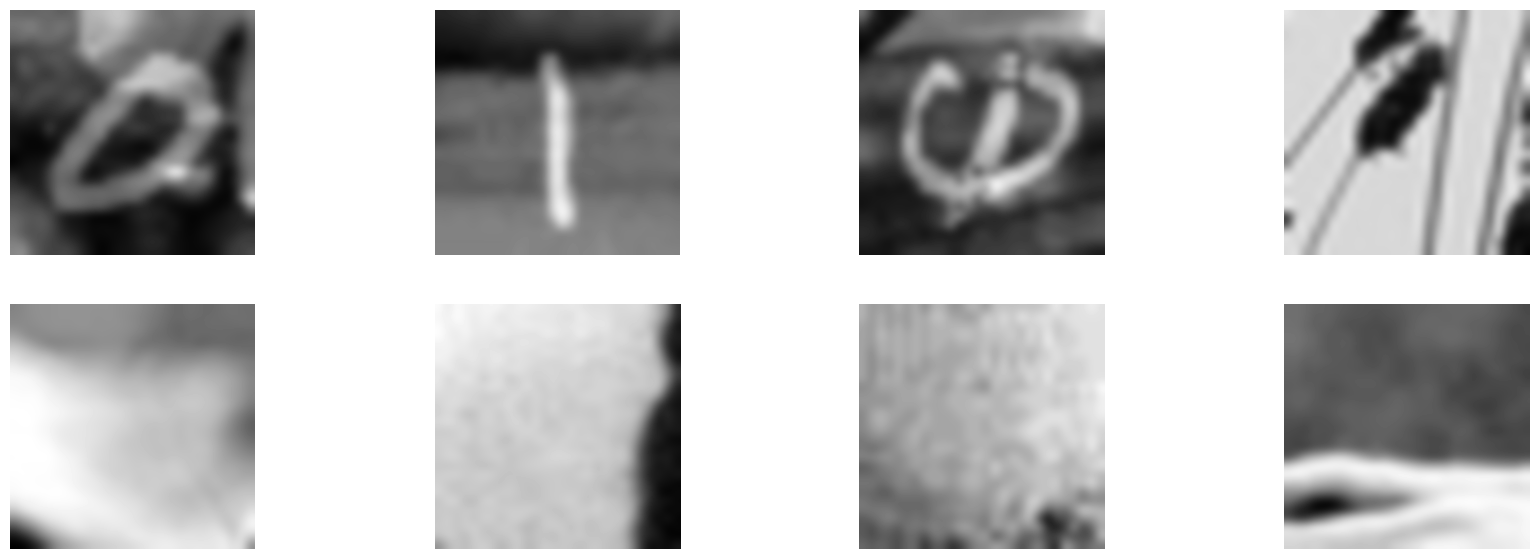

In [63]:
X=np.load("./corrupted_mnist_grass_cloud/X_independent_0_1_clearer.npy")
Y=np.load("./corrupted_mnist_grass_cloud/Y_independent_0_1_clearer.npy")
label = np.load("./corrupted_mnist_grass_cloud/label_independent_0_1_clearer.npy")
n_show = 4

plt.figure(figsize=[21, 7])
idx = [50,2503,5084,7503]
for i in range(n_show):
    plt.subplot(2, n_show, i + 1)
    plt.imshow(
        np.reshape(X[idx[i], :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")


for i in range(n_show):
    plt.subplot(2, n_show, n_show + i + 1)
    idx = np.random.randint(10000)
    plt.imshow(
        np.reshape(Y[idx, :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")
plt.show()

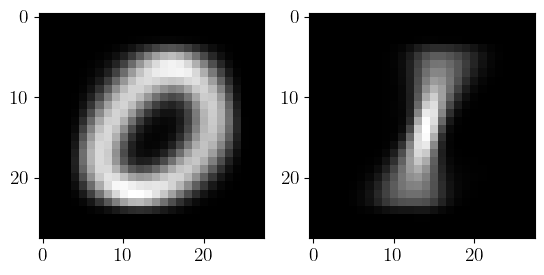

In [23]:
# plot the sample average images
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index_0=np.where(y_train==0)[0]
index_1=np.where(y_train == 1)[0]
foreground=np.zeros(shape = (10000,28,28))
foreground[:2500,:,:]=X_train[index_0][:2500]
foreground[2500:5000,:,:]=X_train[index_1][:2500]
average_0 = np.average(X_train[index_0][:5000,:,:],axis = 0)
average_1 = np.average(X_train[index_1][:5000,:,:],axis = 0)
plt.subplot(1,2,1)
plt.imshow(average_0,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(average_1,cmap='gray')



In [33]:
X=np.load("./corrupted_mnist_grass_cloud/X_independent_0_1_clearer.npy")
Y=np.load("./corrupted_mnist_grass_cloud/Y_independent_0_1_clearer.npy")
label = np.load("./corrupted_mnist_grass_cloud/label_independent_0_1_clearer.npy")

pca=PCA(n_components=30)
pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))

index_0=np.where(label==0)
index_1=np.where(label==1)
index_2=np.where(label==2)
index_3=np.where(label==3)
label=np.hstack((np.zeros(X[index_0].shape[0]),np.ones(X[index_1].shape[0])))
X_0=X[index_0]
X_1=X[index_1]
X_2=X[index_2]
X_3=X[index_3]
X=np.vstack((X[index_0],X[index_1],X[index_2],X[index_3]))
X_pca_0=pca.transform(X_0)
X_pca_1=pca.transform(X_1)
X_pca_2=pca.transform(X_2)
X_pca_3=pca.transform(X_3)
Y_pca=pca.transform(Y)
X_pca=pca.transform(X)

# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
# np.save('corrupted_mnist_grass_cloud/k2_b_independent_0_1_clearer',k2_b)
# np.save('corrupted_mnist_grass_cloud/k2_f_independent_0_1_clearer',k2_f)
# np.save('corrupted_mnist_grass_cloud/k4_b_independent_0_1_clearer',k4_b)
# np.save('corrupted_mnist_grass_cloud/k4_f_independent_0_1_clearer',k4_f)

[0.59090856 0.65019975 0.68587312 0.71963569 0.73570372 0.74928612
 0.76117664 0.7694356  0.77632251 0.78281253 0.78906733 0.79489875
 0.80057309 0.80536753 0.80987463 0.81372686 0.81750523 0.82106652
 0.8240863  0.82696564 0.82960101 0.83213554 0.83461711 0.83705766
 0.83941225 0.84171668 0.84391296 0.8458024  0.84766796 0.84944729]


In [34]:
k4_f=np.load('corrupted_mnist_grass_cloud/k4_f_independent_0_1_clearer.npy')
k4_b=np.load('corrupted_mnist_grass_cloud/k4_b_independent_0_1_clearer.npy')
k2_f=np.load('corrupted_mnist_grass_cloud/k2_f_independent_0_1_clearer.npy')
k2_b=np.load('corrupted_mnist_grass_cloud/k2_b_independent_0_1_clearer.npy')

figsize = (6,8)
def plot_graph_mnist01(directions,xlabel,ylabel,title,sil_score,name):
    fig,axs=plt.subplots(1,1, figsize = figsize)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    axs.scatter(pattern_1@X_pca_0.T,pattern_2@X_pca_0.T,label='digit 0')
    axs.scatter(pattern_1@X_pca_1.T,pattern_2@X_pca_1.T,label='digit 1')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")


def plot_graph_mnist01_4_cases(directions,xlabel,ylabel,title,sil_score):
    fig,axs=plt.subplots(1,1, figsize=figsize)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    axs.scatter(pattern_1@X_pca_0.T,pattern_2@X_pca_0.T,label='digit 0',alpha=0.5)
    axs.scatter(pattern_1@X_pca_1.T,pattern_2@X_pca_1.T,label='digit 1',alpha=0.5)
    axs.scatter(pattern_1@X_pca_2.T,pattern_2@X_pca_2.T,label='digit 0 1',alpha=0.5)
    axs.scatter(pattern_1@X_pca_3.T,pattern_2@X_pca_3.T,label='no digit',alpha=0.5)
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')


def mnist_silhouette(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_pca_0.T,pattern_2@X_pca_0.T))
    cluster_2=np.vstack((pattern_1@X_pca_1.T,pattern_2@X_pca_1.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)

def plot_graph_mnist01_wholedataset(directions,xlabel,ylabel,title,sil_score,name):
    fig,axs=plt.subplots(1,1,figsize=figsize)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_0.T,pattern_2@X_0.T,label='digit 0')
    axs.scatter(pattern_1@X_1.T,pattern_2@X_1.T,label='digit 1')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")


def plot_graph_mnist01_wholedataset_4_cases(directions,xlabel,ylabel,title,sil_score,name):
    fig,axs=plt.subplots(1,1,figsize=figsize)
    pattern_1=directions[:,0].reshape(1,-1)
    pattern_2=directions[:,1].reshape(1,-1)
    # axs[i,j].scatter(pattern_1@Y_pca.T,pattern_2@Y_pca.T,color='b',label='background')
    axs.scatter(pattern_1@X_0.T,pattern_2@X_0.T,label='digit 0')
    axs.scatter(pattern_1@X_1.T,pattern_2@X_1.T,label='digit 1')
    axs.scatter(pattern_1@X_2.T,pattern_2@X_2.T,label='digit 0 1')
    axs.scatter(pattern_1@X_3.T,pattern_2@X_3.T,label='no digit')
    axs.legend()
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.set_title(title+' '+'silhouette score:'+f'{sil_score:0.3f}')
    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(name+".tex")


def mnist_silhouette_wholedataset(directions):
    pattern_1=directions[:,0]
    pattern_2=directions[:,1]
    cluster_1=np.vstack((pattern_1@X_0.T,pattern_2@X_0.T))
    cluster_2=np.vstack((pattern_1@X_1.T,pattern_2@X_1.T))
    cluster_label=np.hstack((np.zeros(cluster_1.shape[1]),np.ones(cluster_2.shape[1])))
    cluster=np.hstack((cluster_1,cluster_2))
    return silhouette_score(cluster.T,cluster_label)



def patternimage_cICA(full_size_pattern):
    range = (full_size_pattern.max()-full_size_pattern.min())
    image = (full_size_pattern-full_size_pattern.min()).reshape(28,28)/range
    return image

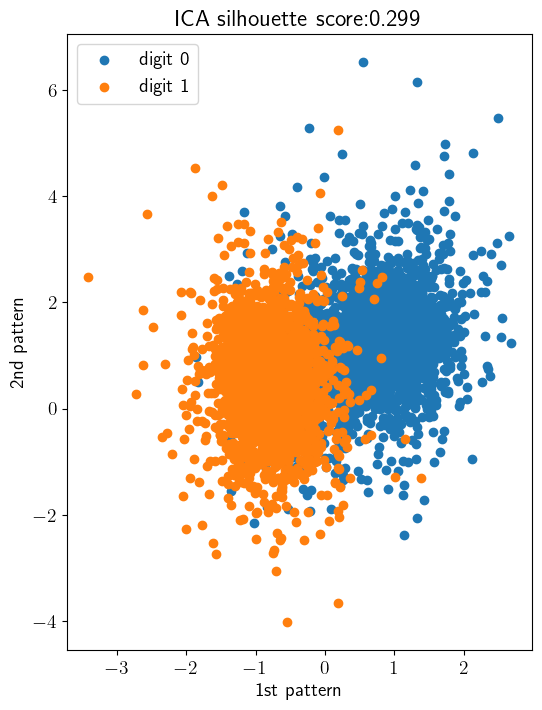

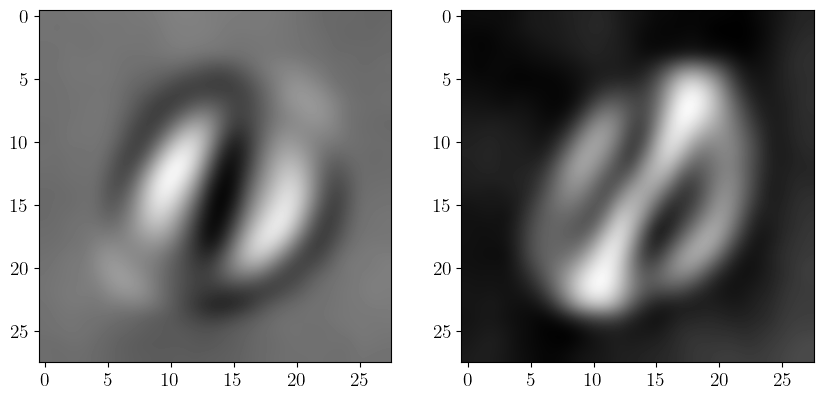

In [35]:
# ICA

np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=0,l=192)
plot_graph_mnist01(b_s_sorted[:,:2],'1st pattern','2nd pattern','ICA',mnist_silhouette(b_s_sorted[:,:2]),"mixed_corrupted_ICA")




#ICA pattern images

full_size_pattern = b_s_sorted.T@pca.components_
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(patternimage_cICA(full_size_pattern[0,:]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(full_size_pattern[1,:]), cmap="gray", interpolation="bicubic")

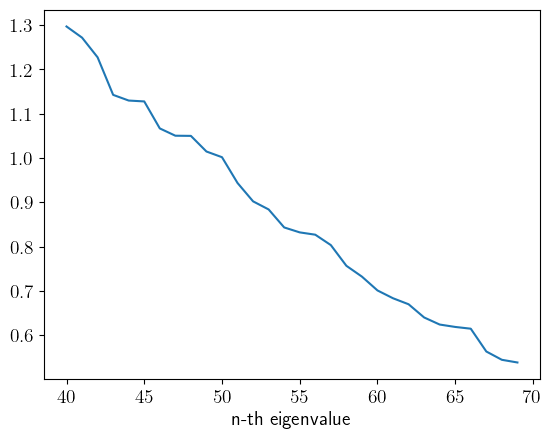

In [80]:
#cICA choices of r
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.figure()
plt.plot(range(40,70),abs(D)[40:70])
plt.xlabel('n-th eigenvalue')
tikzplotlib.save('mixed_corrupted_r')

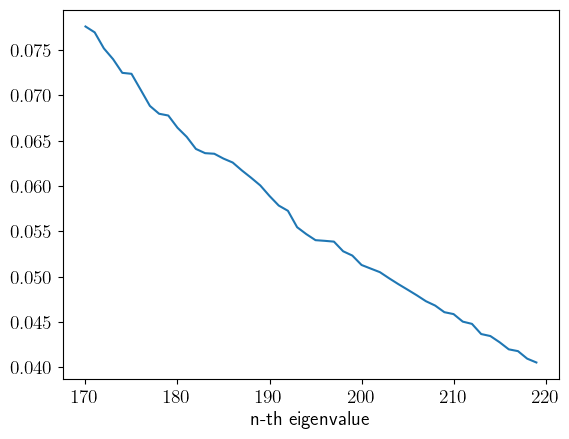

In [84]:
#cICA choices of r+ell
I=k4_f.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.figure()
plt.plot(range(170,220),abs(D)[170:220])
plt.xlabel('n-th eigenvalue')
tikzplotlib.save('mixed_corrupted_r_l.tex')

In [42]:
# adapt the function to also output lambda and lambda'
def recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=None,r=None,l=None):
    I=k4_b.shape[0]
    if r==None:
        # get flattening of k4_b
        matK4b=k4_b.reshape(I**2,I**2)
        # remove repeat entries from matK
        symind, findsym, symindscale = symmetric_indices(I, 2)
        symindscale = np.sqrt(symindscale)
        findsym = findsym.flatten()
        symind = symind[::-1,:].T @ (I ** np.arange(2))
        sym_matK4b = symindscale.reshape(1, -1) * matK4b[symind][:, symind] * symindscale.reshape(-1, 1)
        D_prime,symV_prime=eig2(sym_matK4b)
        eigtol= 1e-12
        rank_k4_b=D_prime.shape[0]-np.searchsorted(abs(D_prime[::-1]), eigtol)
        # r=min(rank_k4_b,I)
        r=rank_k4_b
    
    # recover the a_i vectors (backgroud patterns) & prevent repetitive vectors
    a_s,lambdas=subspace_power_method(k4_b,n=4,d=I,r=r)
    # print("here")
    first_residule=return_residual(k4_b,a_s,lambdas)/(I**4)
    def returnmindistancebewteenvectors(cols):
        def distancebewteenvectors(v1,v2):
            v1=v1.reshape(-1,1)
            v2=v2.reshape(-1,1)
            M=v1@np.transpose(v1)-v2@np.transpose(v2)
            return np.sum(M*M)
        lens=cols.shape[1]
        error=1
        for i in range(lens):
            for j in range(i+1,lens):
                error=min(error,max(distancebewteenvectors(cols[:,i],cols[:,j]),distancebewteenvectors(cols[:,i],-cols[:,j])))
        return error
    step=1
    if step_max==None:
        step_max=100
    while returnmindistancebewteenvectors(a_s)<0.1 and step<step_max:
        a_s,lambdas=subspace_power_method(k4_b,n=4,d=I,r=r)
        step+=1
    # print('step',step)
    
    # get flattening of k4_f,k4_b
    k4_f_copy=k4_f.copy()
    matK4f=k4_f_copy.reshape(I**2,I**2)

    # remove repeat entries from matK
    symind, findsym, symindscale = symmetric_indices(I, 2)
    symindscale = np.sqrt(symindscale)
    findsym = findsym.flatten()
    symind = symind[::-1,:].T @ (I ** np.arange(2))
    sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
    D, symV = eig2(sym_matK4f)
    eigtol= 1e-12
    rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
    D = D[:rank_k4_f]
    V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
    D1 = np.diagflat(1. / D).T
    # print("here")
    # learn coefficients of a_i in k4_f
    lambda_prime=[]
    for a in a_s.T:
        apow = khatri_rao_power(a.reshape(-1, 1), 2)
        alpha = (apow.T @ V).T
        D1alpha = D1 @ alpha
        scalar=(alpha.T @ D1alpha)[0,0]
        k4_f_copy-=(1. / scalar)*generate_lowrank_tensor(a.reshape(-1,1),4)
        lambda_prime.append(1./scalar)
        matK4f=k4_f_copy.reshape(I**2,I**2)
        sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
        D, symV = eig2(sym_matK4f)
        eigtol= 1e-12
        rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
        D = D[:rank_k4_f]
        V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
        D1 = np.diagflat(1. / D).T
    if l==None:
        l=rank_k4_f
        print('l',l)
    
    print(lambda_prime,lambdas)

    Diag,B=eig2(k4_f_copy.reshape(I**2,I**2))
    D_foreground=Diag
    M=k4_f_copy.reshape(I**2,I**2)
    blist=[]
    for n,bpow in enumerate(B.T[:l]):
        bpowmat=bpow.reshape(I,I)
        Diag_prime,eigen=eig2(bpowmat)
        b=eigen[:,0].flatten()
        blist.append(b/np.sum(b*b)**0.5)
        bpow=Diag_prime[0]*khatri_rao_power(b.reshape(-1, 1), 2)
        M-=Diag[n]*bpowmat.reshape(-1,1)@bpowmat.reshape(1,-1)
    blist=np.array(blist).T
    second_residule=np.sum(M*M)/(I**4)
    # rank b_i according to their variance ratio
    contrastvarlist=[]
    fore_varlist=[]
    back_varlist=[]
    for b in blist.T:
        b=b.reshape(-1,1)
        fore_var=(b.T@ k2_f @ b).flatten()
        back_var=(b.T@k2_b @ b).flatten()
        # varlist.append(fore_var)
        contrastvarlist.append(fore_var/back_var)
        fore_varlist.append(fore_var)
        back_varlist.append(back_var)

    contrastind=(-np.array(contrastvarlist)).flatten().argsort().tolist()
    b_s_sorted_contrast= blist[:,contrastind]
    return a_s,b_s_sorted_contrast,np.array(contrastvarlist).flatten()[contrastind],first_residule,second_residule,D_foreground,lambda_prime,lambdas

In [43]:
#cICA
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground, lambda_prime,lambdas=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=51,l=192-51)

[-93.94781555048378, 300.0600898032037, -21.215889725399848, 7.02050115119175, -4.942607558937049, 2.4665279985729707, 1.3673031071062676, 13.741596682212837, -8.372572985759577, 14.535506467651027, 1.9735937560611423, -7.204412457874166, 17.809137759324297, -8.245726480957565, 3.1705154538344646, 4.637959813653723, 358.5927397534953, -343.69816371846235, 5.8180971110205935, 29.256982789061425, -33.46584755134419, 76.15902686809865, -2.591429990995562, 51.10101282926954, -12.961699561639541, -19.01247518066415, -3.5942459439512215, 114.15911363247828, 55.91858933346598, -257.4794808653832, 37.8091359087717, 169.169935933143, 301.33792287017, 309.4629741757649, -17.862615228562806, -27.490321995191696, 27.041158494755457, -424.98572412598054, -14.74138279561181, -300.30512707487617, 310.99976767952376, -216.80557639844423, -131.70586846807234, -376.1086320757443, -585.7520977652063, 688.2975751021404, -127.90004418044968, 1.2904784154720097, 2.9236549206913454, 28.662926777795366, 24.46

In [67]:
cumulant_ratio = abs(np.array(lambda_prime)/lambdas)
cumulant_ratio.max(),cumulant_ratio.min(),lambda_prime,cumulant_ratio

(15.980436808459089,
 0.006744674644809884,
 [-93.94781555048378,
  300.0600898032037,
  -21.215889725399848,
  7.02050115119175,
  -4.942607558937049,
  2.4665279985729707,
  1.3673031071062676,
  13.741596682212837,
  -8.372572985759577,
  14.535506467651027,
  1.9735937560611423,
  -7.204412457874166,
  17.809137759324297,
  -8.245726480957565,
  3.1705154538344646,
  4.637959813653723,
  358.5927397534953,
  -343.69816371846235,
  5.8180971110205935,
  29.256982789061425,
  -33.46584755134419,
  76.15902686809865,
  -2.591429990995562,
  51.10101282926954,
  -12.961699561639541,
  -19.01247518066415,
  -3.5942459439512215,
  114.15911363247828,
  55.91858933346598,
  -257.4794808653832,
  37.8091359087717,
  169.169935933143,
  301.33792287017,
  309.4629741757649,
  -17.862615228562806,
  -27.490321995191696,
  27.041158494755457,
  -424.98572412598054,
  -14.74138279561181,
  -300.30512707487617,
  310.99976767952376,
  -216.80557639844423,
  -131.70586846807234,
  -376.108632075

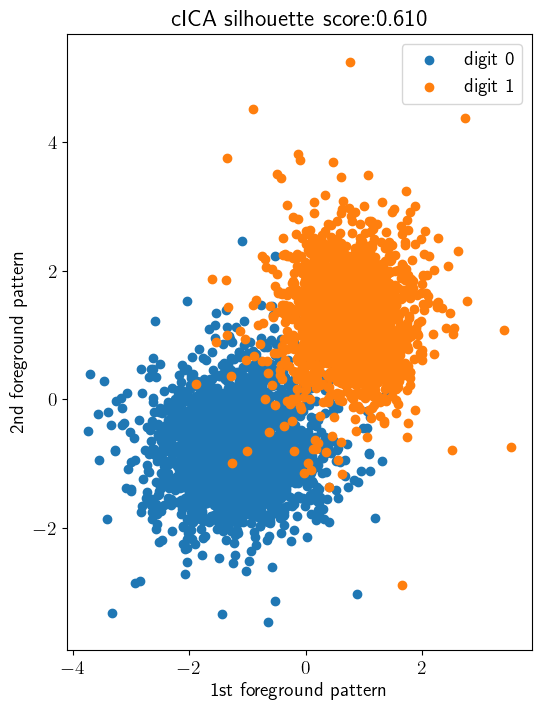

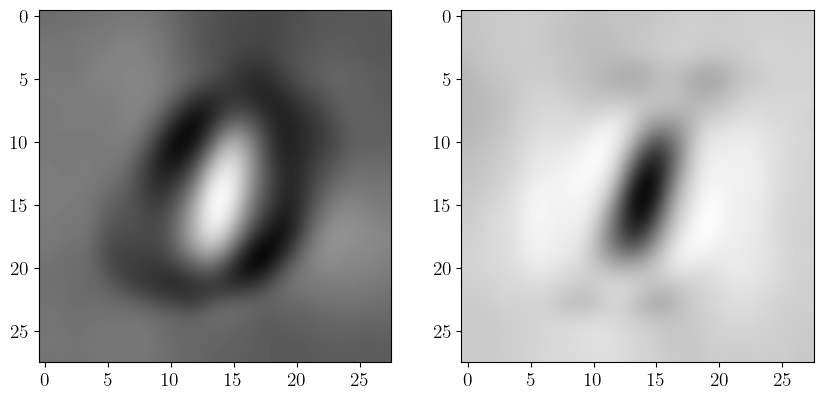

In [45]:
# visualization plot

plot_graph_mnist01(b_s_sorted[:,:2],'1st foreground pattern','2nd foreground pattern','cICA',mnist_silhouette(b_s_sorted[:,:2]),"mixed_corrupted_cICA.tex")


#cICA image
full_size_pattern = b_s_sorted.T@pca.components_
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(patternimage_cICA(full_size_pattern[0,:]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(-full_size_pattern[1,:]), cmap="gray", interpolation="bicubic")

In [24]:
array_1 = b_s_sorted[:,0]@ X_pca[:2500,:].T
array_2 = b_s_sorted[:,0]@ X_pca[2500:5000,:].T
(np.sum(array_1<0)+np.sum(array_2>0))/5000

0.94

In [25]:
array_1 = b_s_sorted[:,1]@ X_pca[:2500,:].T
array_2 = b_s_sorted[:,1]@ X_pca[2500:5000,:].T
(np.sum(array_1<0)+np.sum(array_2>0))/5000

0.9306

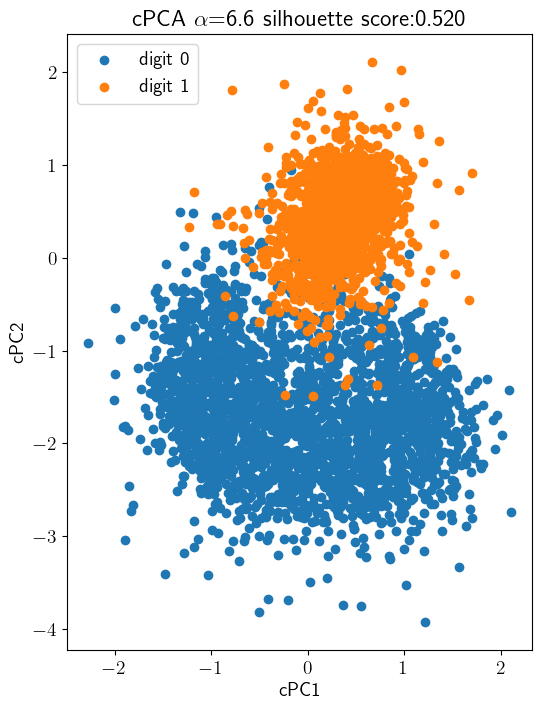

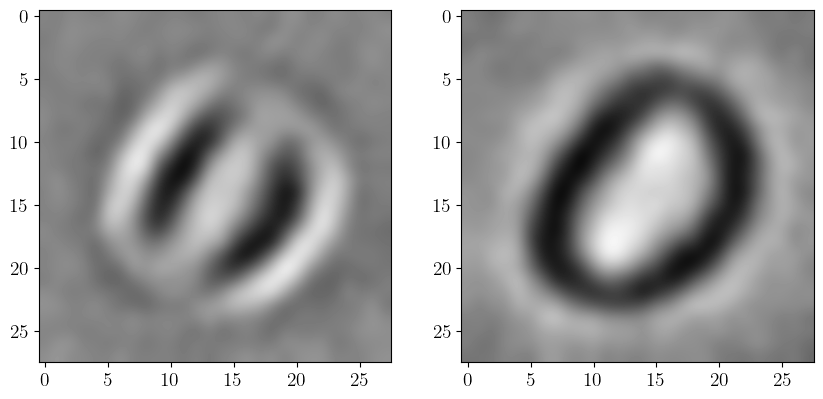

In [76]:
#CPCA whole dataset
mdl=CPCA()
silhouette_score_list=[]
l,alphas=mdl.fit_transform(X,Y,n_alphas=100,return_alphas=True,max_log_alpha=3)
for array in l:
    silhouette_score_list.append(silhouette_score(array[:5000,:],label[:5000]))
index=np.argmax(np.array(silhouette_score_list))
alpha=alphas[index]

D,V=np.linalg.eig(mdl.fg_cov-alpha*mdl.bg_cov)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
plot_graph_mnist01_wholedataset(b_cpca,'cPC1','cPC2',f'cPCA $\\alpha$={alpha:0.1f}',silhouette_score_list[index],"mixed_corrupted_cPCA")
directions=b_cpca
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(patternimage_cICA(b_cpca[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(b_cpca[:,1]), cmap="gray", interpolation="bicubic")

In [28]:
array_1 = b_cpca[:,0]@ X[:2500,:].T
array_2 = b_cpca[:,0]@ X[2500:5000,:].T
max((np.sum(array_1<0)+np.sum(array_2>0))/5000, 1-(np.sum(array_1<0)+np.sum(array_2>0))/5000)

0.7106

In [29]:
array_1 = b_cpca[:,1]@ X[:2500,:].T
array_2 = b_cpca[:,1]@ X[2500:5000,:].T
max((np.sum(array_1<0)+np.sum(array_2>0))/5000, 1-(np.sum(array_1<0)+np.sum(array_2>0))/5000)

0.9442

In [ ]:
#PCPCA on whole dataset choose gamma
silhouette_score_list=[]
b_list=[]
n, m = X.shape[0], Y.shape[0]
i=0
for gamma in np.linspace(0,0.9,100):
    print(i)
    i+=1
    pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
    X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
    b=pcpca.W_mle
    # b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
    silhouette_score_list.append(mnist_silhouette_wholedataset(b))
    b_list.append(b)
index=np.argmax(np.array(silhouette_score_list))
gamma=np.linspace(0,0.9,100)[index]
plot_graph_mnist01_wholedataset(b_list[index],'PCPC1','PCPC2',f'PCPCA $\gamma$={gamma}',silhouette_score_list[index])

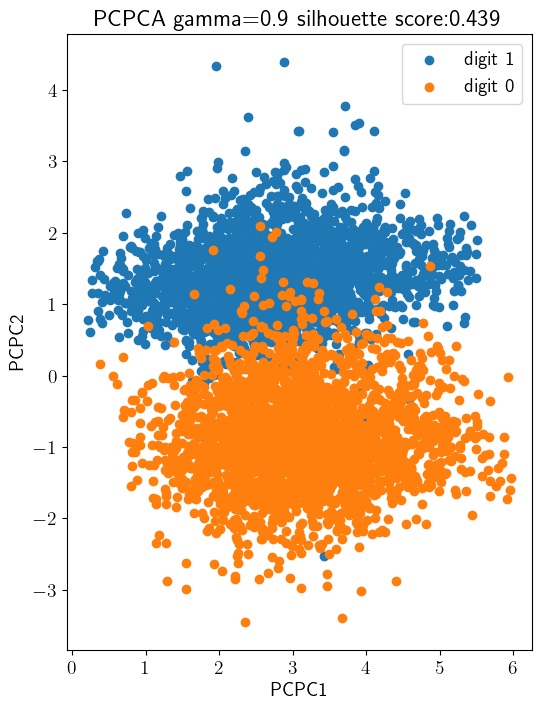

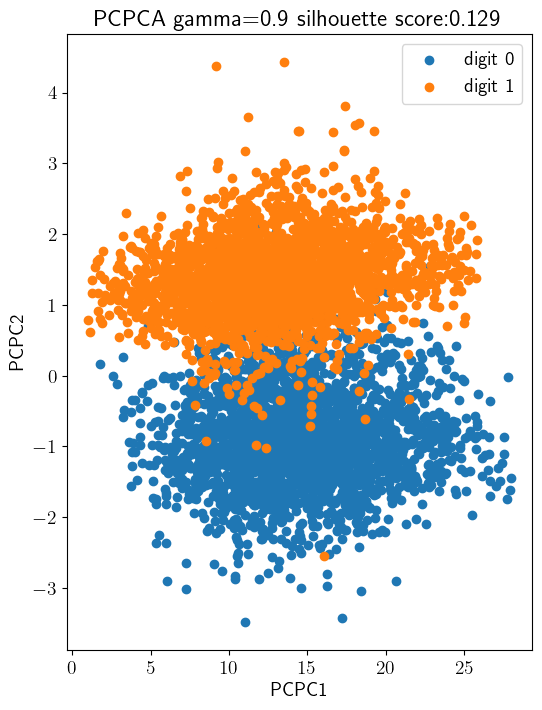

In [78]:
#PCPCA whole dataset
# normlize X,Y
gamma=0.9
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
X_reduced,Y_reduced=pcpca.fit_transform(X.T,Y.T)
X_reduced = (X_reduced.T / X_reduced.T.std(0)).T
# Y_reduced = (Y_reduced.T / X_reduced.T.std(0)).T
fig,axs=plt.subplots(1,1,figsize= figsize)
# axs.scatter(Y_reduced[0,:].T,Y_reduced[1,:].T,label='background')
axs.scatter(X_reduced[0,np.where(label==1)].T,X_reduced[1,np.where(label==1)].T,label='digit 1')
axs.scatter(X_reduced[0,np.where(label==0)].T,X_reduced[1,np.where(label==0)].T,label='digit 0')

axs.legend()
axs.set_xlabel('PCPC1')
axs.set_ylabel('PCPC2')
sil_score=silhouette_score(X_reduced.T[:5000,:],label[:5000])
axs.set_title('PCPCA'+f' gamma={gamma}'+' '+'silhouette score:'+f'{sil_score:0.3f}')

tikzplotlib_fix_ncols(fig)
tikzplotlib.save("mixed_corrupted_PCPCA.tex")

# normalize b
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
plot_graph_mnist01_wholedataset(b[:,[0,1]],'PCPC1','PCPC2',f'PCPCA gamma={gamma}',mnist_silhouette_wholedataset(b[:,[0,1]]),"delete")

In [31]:
array_1 = b[:,0]@ X[:2500,:].T
array_2 = b[:,0]@ X[2500:5000,:].T
max((np.sum(array_1<0)+np.sum(array_2>0))/5000, 1-(np.sum(array_1<0)+np.sum(array_2>0))/5000)

0.5

In [32]:
array_1 = b[:,1]@ X[:2500,:].T
array_2 = b[:,1]@ X[2500:5000,:].T
max((np.sum(array_1<0)+np.sum(array_2>0))/5000, 1-(np.sum(array_1<0)+np.sum(array_2>0))/5000)

0.9398

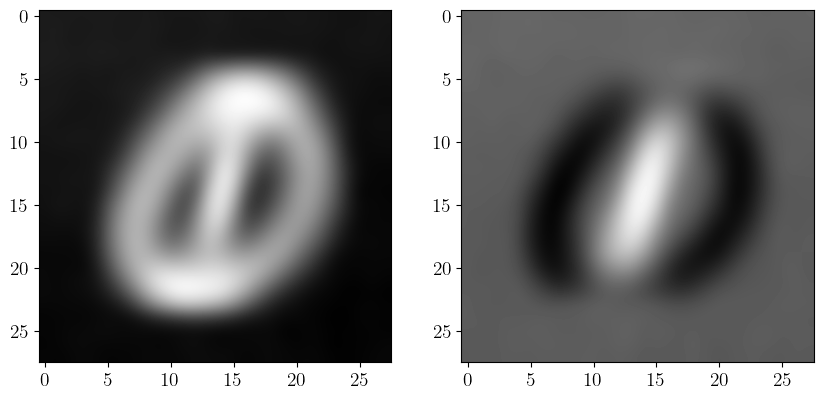

In [110]:
#PCPCA image
pattern = pcpca.W_mle
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(patternimage_cICA(pattern[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(pattern[:,1]), cmap="gray", interpolation="bicubic")

# MNIST continuous strength

In [27]:
# background 50% grass, 50% cloud, foreground 80% grass, 20% cloud
# grass images are downloaded from imagenet with id n12102133
import keras
from keras.datasets import mnist
np.random.seed(0)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index_0=np.random.choice(list(np.where(y_train==0)[0]),10000,replace = True)
index_1=np.random.choice(list(np.where(y_train == 1)[0]),10000, replace = True)
strength = np.random.uniform(0,1,(2,10000))
foreground=np.zeros(shape = (10000,28,28))
for i in range(10000):
    foreground[i,:]=(X_train[index_0[i]]*strength[0,i]+X_train[index_1[i]]*strength[1,i])/255



from PIL import Image
from resizeimage import resizeimage
import os

grass_IMAGE_PATH = 'n12102133/' #Replace with your own path to downloaded images
cloud_IMAGE_PATH = 'n09247410/' #Replace with your own path to downloaded images
        
grass_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
num=0
for filename in os.listdir(grass_IMAGE_PATH):
    num+=1
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(grass_IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale

            im = resizeimage.resize_crop(im,[100,100]) #resize and crop each picture to be 100px by 100px
            grass_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
            
grass_images=np.asarray(grass_images,dtype=float)
grass_images/=255 #rescale to be 0-1
print("Array of grass images:",grass_images.shape)


cloud_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
num=0
for filename in os.listdir(cloud_IMAGE_PATH):
    num+=1
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(cloud_IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale

            im = resizeimage.resize_crop(im,[100,100]) #resize and crop each picture to be 100px by 100px
            cloud_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
    
cloud_images=np.asarray(cloud_images,dtype=float)
cloud_images/=255 #rescale to be 0-1
print("Array of cloud images:",cloud_images.shape)
# Corrupt the MNIST digits with the grass and cloud images 
from tqdm import tqdm

np.random.seed(0)  # for reproducibility

grass_rand_indices = np.random.permutation(
    grass_images.shape[0]
)  # just shuffles the indices
grass_split = int(len(grass_rand_indices) / 2)
target_grass_indices = grass_rand_indices[
    0:grass_split
]  # choose the first half of images to be superimposed on target
background_grass_indices = grass_rand_indices[
    grass_split:
]  # choose the second half of images to be background dataset



cloud_rand_indices = np.random.permutation(
    cloud_images.shape[0]
)  # just shuffles the indices
cloud_split = int(len(cloud_rand_indices) / 2)
target_cloud_indices = cloud_rand_indices[
    0:cloud_split
]  # choose the first half of images to be superimposed on target
background_cloud_indices = cloud_rand_indices[
    cloud_split:
]  # choose the second half of images to be background dataset

target = np.zeros((foreground.shape[0],28**2))
background = np.zeros((foreground.shape[0],28**2))


permuted_index = np.random.permutation(10000)
print("Corrupting MNIST with grass and cloud...")
grass_cloud_foreground = np.zeros((foreground.shape[0],28**2))
for i in range(int(target.shape[0]/10*8)):
    idx = np.random.choice(target_grass_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(grass_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784]) 
    grass_cloud_foreground[i]=superimposed_patch
    # foregroundreshaped=foreground[i].reshape(1,-1)
    # target[permuted_index[i]] = 0.25* foregroundreshaped/255+ superimposed_patch

for i in range(int(target.shape[0]/10*8),target.shape[0]):
    idx = np.random.choice(target_cloud_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(cloud_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    grass_cloud_foreground[i]=superimposed_patch
    # foregroundreshaped=foreground[i].reshape(1,-1)
    # target[permuted_index[i]] = 0.25* foregroundreshaped/255+ superimposed_patch

for i in range(10000):
    foregroundreshaped=foreground[i].reshape(1,-1)
    target[i] = foregroundreshaped+ grass_cloud_foreground[permuted_index[i]]

for i in range(target.shape[0]//2):
    idx = np.random.choice(background_grass_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(grass_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    background[permuted_index[i]] = background_patch

    idx = np.random.choice(background_cloud_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(cloud_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    background[permuted_index[i+target.shape[0]//2]] = background_patch


      

np.save("./mixed_MNIST_continuous/X.npy", target)
np.save("./mixed_MNIST_continuous/Y.npy", background)

Array of grass images: (1269, 10000)
Array of cloud images: (1399, 10000)
Corrupting MNIST with grass and cloud...


[8069 1084 2951 4526]
[4568 4489 5905  866]


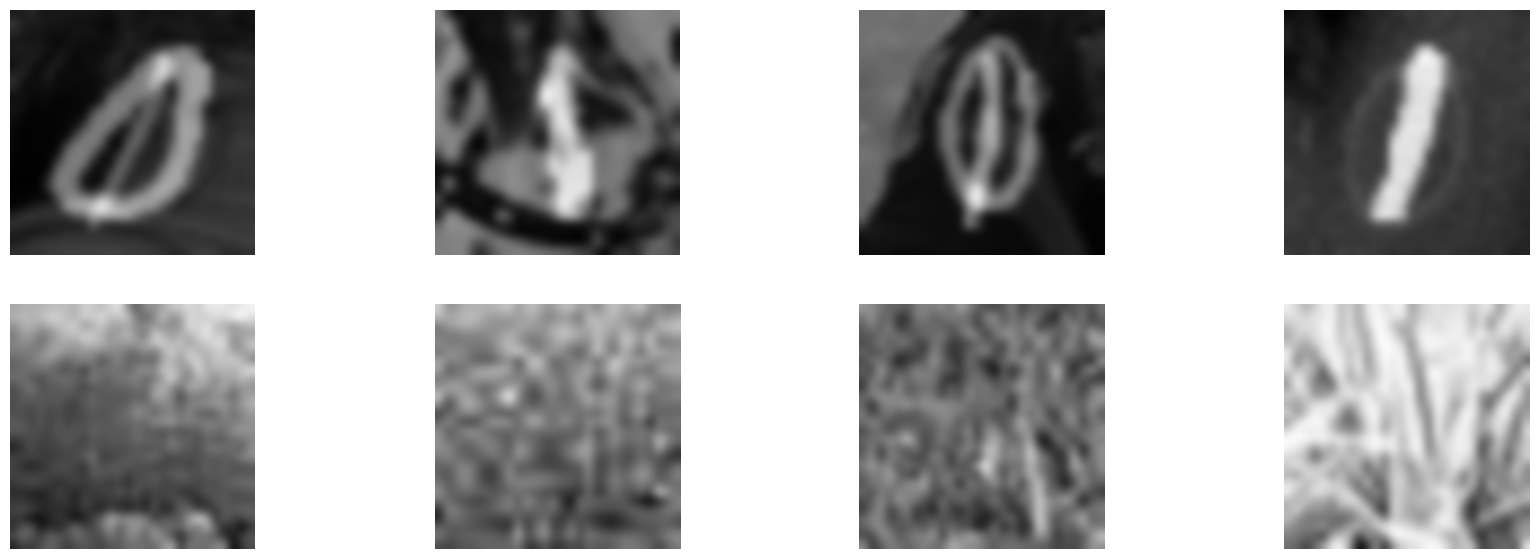

In [48]:
X=np.load("./mixed_MNIST_continuous/X.npy")
Y=np.load("./mixed_MNIST_continuous/Y.npy")
n_show = 4

plt.figure(figsize=[21, 7])
idx = np.random.choice(range(10000),4)
print(idx)
for i in range(n_show):
    plt.subplot(2, n_show, i + 1)
    plt.imshow(
        np.reshape(X[idx[i], :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")

idx = np.random.choice(range(10000),4)
print(idx)
for i in range(n_show):
    plt.subplot(2, n_show, n_show + i + 1)
    plt.imshow(
        np.reshape(Y[idx[i], :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")
plt.show()


In [49]:
pca=PCA(n_components=30)
X_centered = X-np.mean(X,axis=0,keepdims=True)
Y_centered = Y-np.mean(Y,axis=0,keepdims=True)
pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))
Y_pca=pca.transform(Y_centered)
X_pca=pca.transform(X_centered)


# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
# np.save('mixed_MNIST_continuous/k2_b',k2_b)
# np.save('mixed_MNIST_continuous/k2_f',k2_f)
# np.save('mixed_MNIST_continuous/k4_b',k4_b)
# np.save('mixed_MNIST_continuous/k4_f',k4_f)

k4_f=np.load('mixed_MNIST_continuous/k4_f.npy')
k4_b=np.load('mixed_MNIST_continuous/k4_b.npy')
k2_f=np.load('mixed_MNIST_continuous/k2_f.npy')
k2_b=np.load('mixed_MNIST_continuous/k2_b.npy')

[0.47491477 0.58192339 0.62332007 0.6510176  0.67588209 0.69804601
 0.71772756 0.73380596 0.74730012 0.7561417  0.76401646 0.77146232
 0.77777041 0.78369109 0.7894887  0.7945654  0.79958979 0.80445756
 0.80900658 0.81351237 0.81748071 0.82116048 0.82465071 0.82807925
 0.83145056 0.8344232  0.83727176 0.83998516 0.84262449 0.845112  ]


In [50]:
def patternimage_cICA(full_size_pattern):
    image = (full_size_pattern-full_size_pattern.min()).reshape(28,28)
    return image

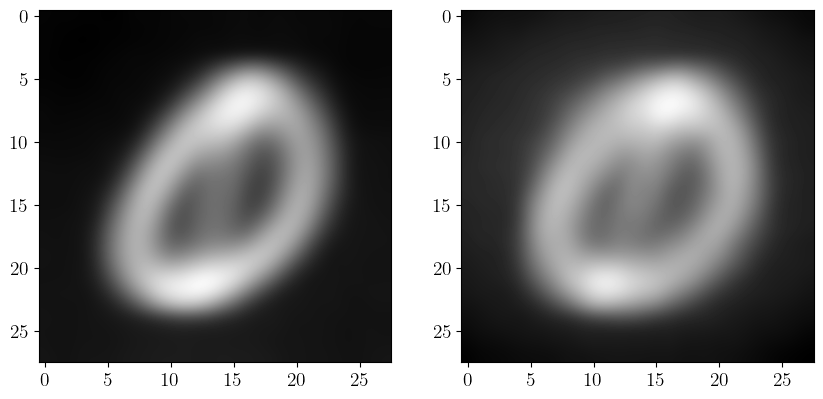

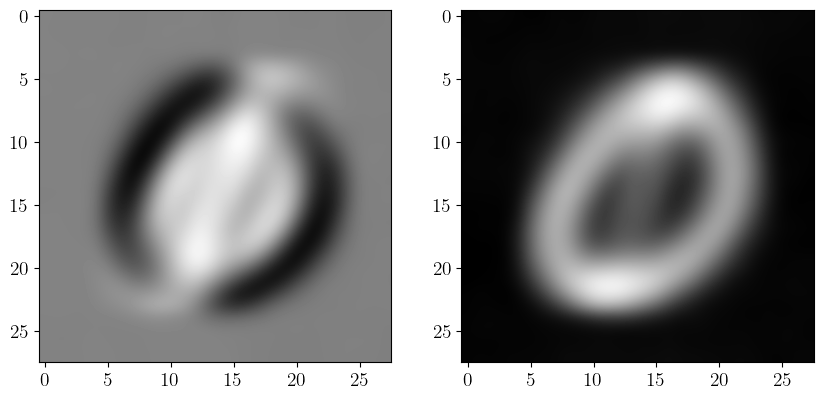

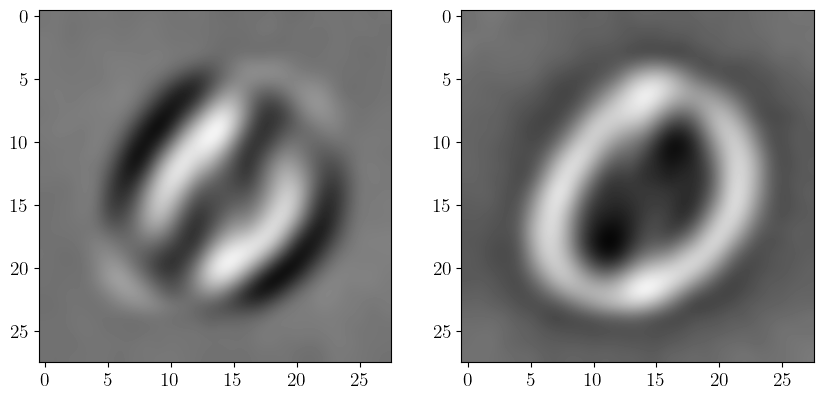

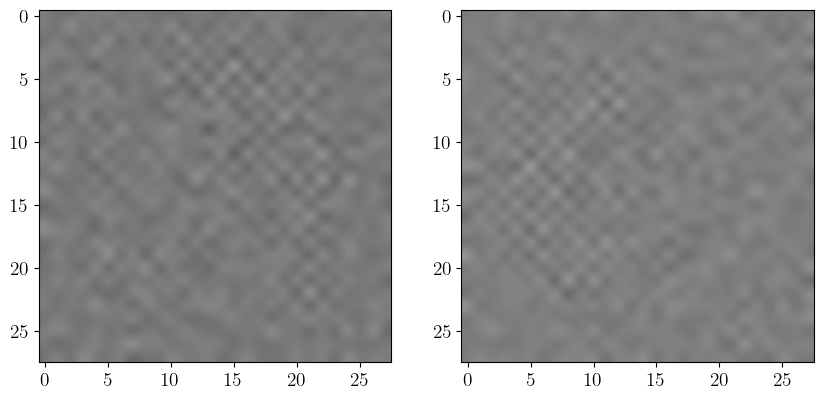

In [117]:
# cPCA 
mdl=CPCA()
l,alphas=mdl.fit_transform(X,Y,return_alphas=True,n_alphas_to_return=4)
k2_full_f = np.cov(X.T)
k2_full_b = np.cov(Y.T)
for alpha in alphas:
    D,V=np.linalg.eig(k2_full_f-alpha*k2_full_b)
    eig_idx = np.argpartition(D, -2)[-2:]
    b_cpca=V[:,eig_idx]
    full_size_pattern = b_cpca
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(patternimage_cICA(full_size_pattern[:,0]), cmap="gray", interpolation="bicubic")
    axes[1].imshow(patternimage_cICA(full_size_pattern[:,1]), cmap="gray", interpolation="bicubic")




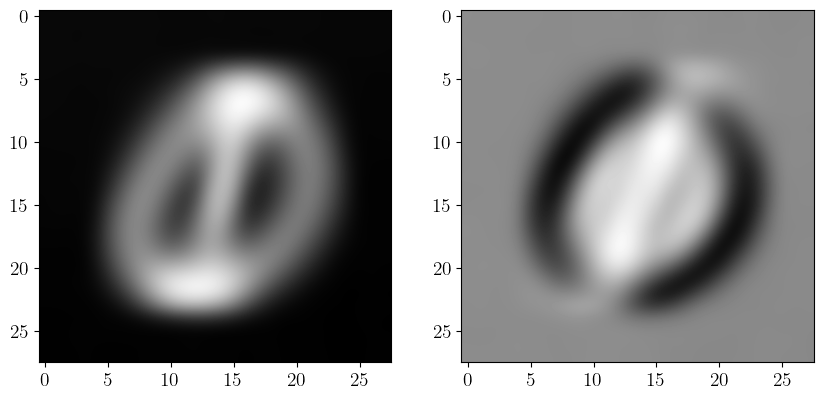

In [51]:
# PCPCA
#PCPCA with gamma = 0.9
gamma = 0.9
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
pcpca.fit(X.T,Y.T)
b=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
full_size_pattern = b
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(patternimage_cICA(full_size_pattern[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(full_size_pattern[:,1]), cmap="gray", interpolation="bicubic")

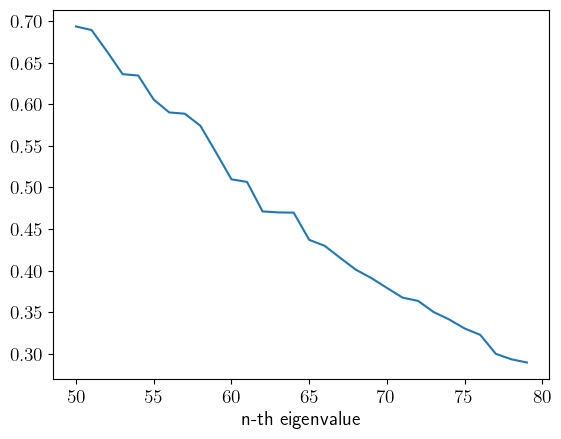

In [12]:
# choice of r
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.figure()
plt.plot(range(50,80),abs(D)[50:80])
plt.xlabel('n-th eigenvalue')

tikzplotlib.save('corrupted_r_continuous.tex')


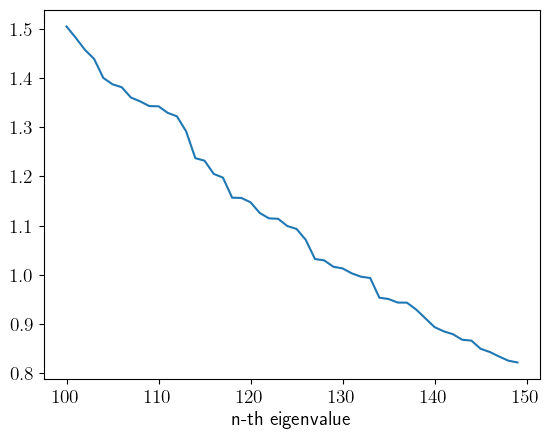

In [12]:
# choice of r+l
I=k4_f.shape[0]
D,V=eig2(k4_f.reshape(I**2,I**2))
plt.figure()
plt.plot(range(100,150),abs(D)[100:150])
plt.xlabel('n-th eigenvalue')
tikzplotlib.save('corrupted_r_ell_continuous.tex')


In [52]:
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground,lambda_prime,lambdas=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=65,l=65)

[99.96049940699993, -155.87474218816624, 14.196621475428447, 4.535953638137835, -15.193242443994446, 7.106766818031557, 55.45070818452907, -28.353753605721074, 4.652026829675447, -3.0304025085159063, -7.811536749590497, 3.5092161309420735, 1.8705800568179896, -10.871729357675573, -0.43213212066507983, 0.6063749426778042, 2.9019158227485775, 1816.0810106199194, -0.30930022253036743, 10.641442335857509, -11.756304184106694, 16.82319181530558, -1.7772677746892118, -14.685433801681306, 8.795441277205414, 3.6312609028189247, 16.20397651535713, -23.32450784718286, -304.77536516983713, 360.15274474305846, 1.41043725738718, -3.15139824822178, 3.7000731297560083, -6.478274986129562, -9.19895312929374, 36.039190430986885, 13.590545396134935, 53.96292474412338, -9.490270981180162, -12.067696635997283, 11.637841316366224, 13.664992627769754, -17.74994521566595, 16.384358828113754, -407.09348077623406, -23.230635992253717, -133.65131119452664, 95.6863642389388, -99.21476324180094, 83.16844002945703

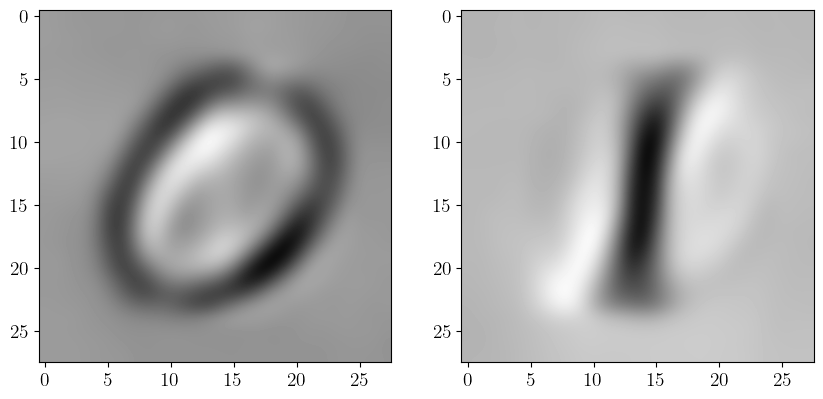

In [54]:
#cICA image
full_size_pattern = b_s_sorted.T@pca.components_
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(-patternimage_cICA(full_size_pattern[0,:]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(-full_size_pattern[1,:]), cmap="gray", interpolation="bicubic")

In [55]:
cumulant_ratio = abs(np.array(lambda_prime)/lambdas)
cumulant_ratio.max(),cumulant_ratio.min(),lambda_prime,cumulant_ratio

(91.33842593092426,
 0.007166065937837076,
 [99.96049940699993,
  -155.87474218816624,
  14.196621475428447,
  4.535953638137835,
  -15.193242443994446,
  7.106766818031557,
  55.45070818452907,
  -28.353753605721074,
  4.652026829675447,
  -3.0304025085159063,
  -7.811536749590497,
  3.5092161309420735,
  1.8705800568179896,
  -10.871729357675573,
  -0.43213212066507983,
  0.6063749426778042,
  2.9019158227485775,
  1816.0810106199194,
  -0.30930022253036743,
  10.641442335857509,
  -11.756304184106694,
  16.82319181530558,
  -1.7772677746892118,
  -14.685433801681306,
  8.795441277205414,
  3.6312609028189247,
  16.20397651535713,
  -23.32450784718286,
  -304.77536516983713,
  360.15274474305846,
  1.41043725738718,
  -3.15139824822178,
  3.7000731297560083,
  -6.478274986129562,
  -9.19895312929374,
  36.039190430986885,
  13.590545396134935,
  53.96292474412338,
  -9.490270981180162,
  -12.067696635997283,
  11.637841316366224,
  13.664992627769754,
  -17.74994521566595,
  16.38435

# MNIST 0 1 3 6 continuous strength

In [39]:
# uniform strength
import keras
import random
from keras.datasets import mnist
np.random.seed(0)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index_0=np.random.choice(list(np.where(y_train==0)[0]),10000,replace = True)
index_1=np.random.choice(list(np.where(y_train == 1)[0]),10000, replace = True)
index_3=np.random.choice(list(np.where(y_train == 3)[0]),20000, replace = True)
index_6=np.random.choice(list(np.where(y_train == 6)[0]),20000, replace = True)

strength = np.random.uniform(0,1,(6,10000))
foreground=np.zeros(shape = (10000,28*28))
background = np.zeros(shape = (10000,28*28))
for i in range(10000):
    foreground_matrix = strength[0,i]*X_train[index_0[i]]+strength[1,i]*X_train[index_1[i]]+strength[2,i]*X_train[index_3[i]].T+strength[3,i]*X_train[index_6[i]].T
    foreground[i,:] = foreground_matrix.reshape(1,-1)
    background_matrix = strength[4,i]*X_train[index_3[i+10000]].T+strength[5,i]*X_train[index_6[i+10000]].T
    background[i,:]= background_matrix.reshape(1,-1)


foreground = (foreground+np.random.normal(0,0.1,size = (20000,784))[:10000,:])/255
background = (background+np.random.normal(0,0.1,size = (20000,784))[10000:,:])/255


      

np.save("./MNIST_continuous/X.npy", foreground)
np.save("./MNIST_continuous/Y.npy", background)


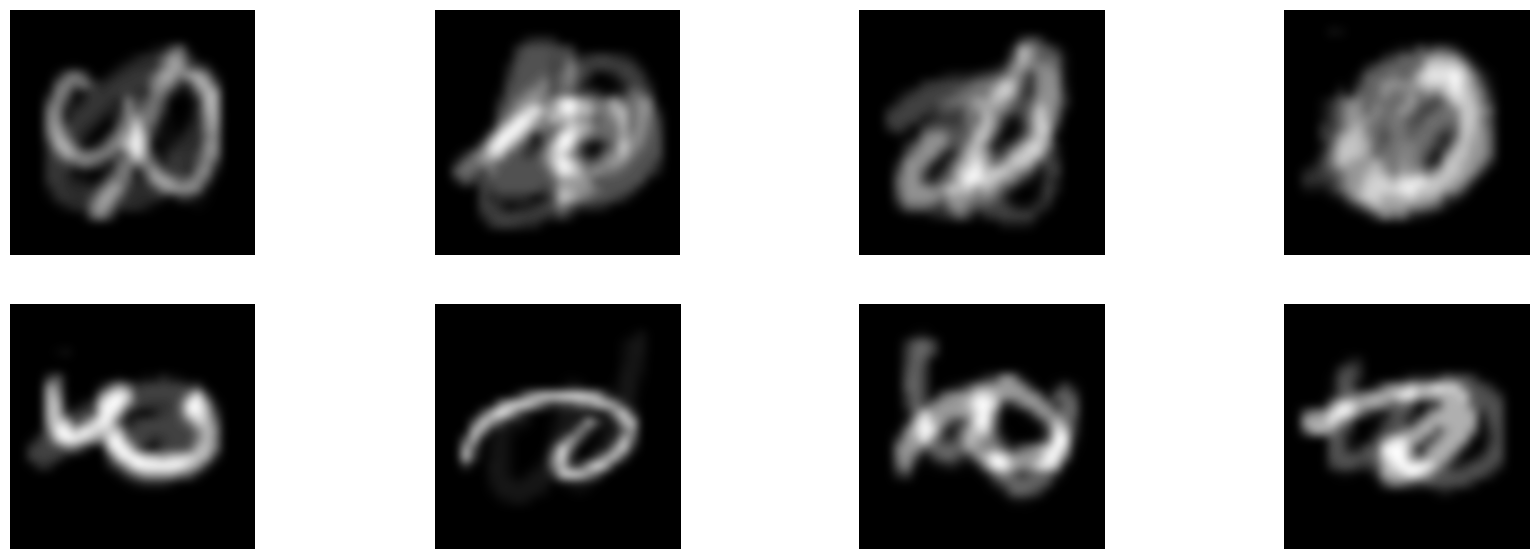

In [57]:
X=np.load("./MNIST_continuous/X.npy")
Y=np.load("./MNIST_continuous/Y.npy")
n_show = 4

plt.figure(figsize=[21, 7])
idx = np.random.randint(0,10000,4)
for i in range(n_show):
    plt.subplot(2, n_show, i + 1)
    plt.imshow(
        np.reshape(X[idx[i], :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")


for i in range(n_show):
    plt.subplot(2, n_show, n_show + i + 1)
    idx = np.random.randint(10000)
    plt.imshow(
        np.reshape(Y[idx, :], [28, 28]), cmap="gray", interpolation="bicubic"
    )
    plt.axis("off")
plt.show()

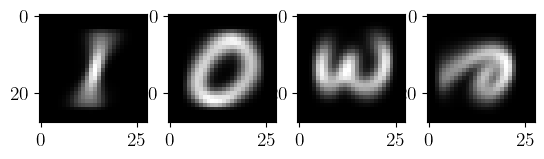

In [62]:
import keras
import random
from keras.datasets import mnist
np.random.seed(0)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index_0=np.random.choice(list(np.where(y_train==0)[0]),10000,replace = True)
index_1=np.random.choice(list(np.where(y_train == 1)[0]),10000, replace = True)
index_3=np.random.choice(list(np.where(y_train == 3)[0]),20000, replace = True)
index_6=np.random.choice(list(np.where(y_train == 6)[0]),20000, replace = True)
strength = np.random.uniform(0,1,(6,10000))

scaled_images_0 = np.zeros((10000,28,28))
scaled_images_1 = np.zeros((10000,28,28))
for i in range(10000):
    scaled_images_0[i] = X_train[index_0[i]]*strength[0,i]
    scaled_images_1[i] = X_train[index_1[i]]*strength[1,i]
avarage_6 = np.average(X_train[index_6],axis = 0)
avarage_3 = np.average(X_train[index_3],axis = 0)
aberage_1 = np.average(scaled_images_0,axis = 0)
average_0 = np.average(scaled_images_1,axis = 0)
plt.subplot(1,4,1)
plt.imshow(average_0,cmap='gray')
plt.subplot(1,4,2)
plt.imshow(aberage_1,cmap='gray')
plt.subplot(1,4,3)
plt.imshow(avarage_3.T,cmap='gray')
plt.subplot(1,4,4)
plt.imshow(avarage_6.T,cmap='gray')

normed_1 = aberage_1.reshape(-1,1)/np.linalg.norm(aberage_1.reshape(-1,1))
normed_0 = average_0.reshape(-1,1)/np.linalg.norm(average_0.reshape(-1,1))

In [56]:
pca=PCA(n_components=30)
X_centered = X-np.mean(X,axis=0,keepdims=True)
Y_centered = Y-np.mean(Y,axis=0,keepdims=True)
pca.fit(np.vstack((X,Y)))
print(np.cumsum(pca.explained_variance_ratio_))
Y_pca=pca.transform(Y_centered)
X_pca=pca.transform(X_centered)


# k2_f,k4_f=cumulant_tensors(X_pca)
# k2_b,k4_b=cumulant_tensors(Y_pca)
# np.save('MNIST_continuous/k2_b',k2_b)
# np.save('MNIST_continuous/k2_f',k2_f)
# np.save('MNIST_continuous/k4_b',k4_b)
# np.save('MNIST_continuous/k4_f',k4_f)

k4_f=np.load('MNIST_continuous/k4_f.npy')
k4_b=np.load('MNIST_continuous/k4_b.npy')
k2_f=np.load('MNIST_continuous/k2_f.npy')
k2_b=np.load('MNIST_continuous/k2_b.npy')

[0.47491477 0.58192339 0.62332007 0.6510176  0.67588209 0.69804601
 0.71772756 0.73380596 0.74730012 0.7561417  0.76401646 0.77146232
 0.77777041 0.78369109 0.7894887  0.79456541 0.79958979 0.80445756
 0.80900659 0.81351238 0.81748075 0.82116056 0.82465086 0.82807978
 0.83145116 0.83442382 0.83727338 0.83999023 0.84263042 0.84512154]


In [59]:
def patternimage_cICA(full_size_pattern):
    image = (full_size_pattern-full_size_pattern.min()).reshape(28,28)
    return image

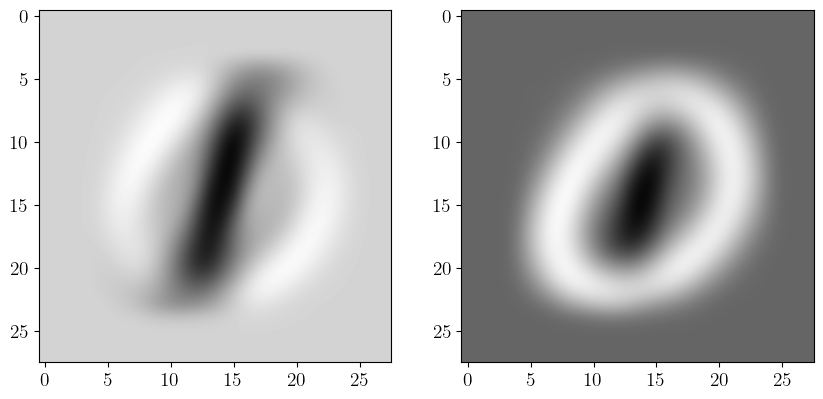

In [64]:
# ASSUME WE JUST HAVE digits 0 and 1, then what PCA gives us.
np.random.seed(0)
digits_01=np.vstack((scaled_images_0.reshape(-1,784), scaled_images_1.reshape(-1,784)))+np.random.normal(0,0.1,(20000,784))
D,V=np.linalg.eig(np.cov(digits_01.T))
eig_idx = np.argpartition(D, -2)[-2:]
top_2=V[:,eig_idx]
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(-patternimage_cICA(top_2[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(top_2[:,1]), cmap="gray", interpolation="bicubic")

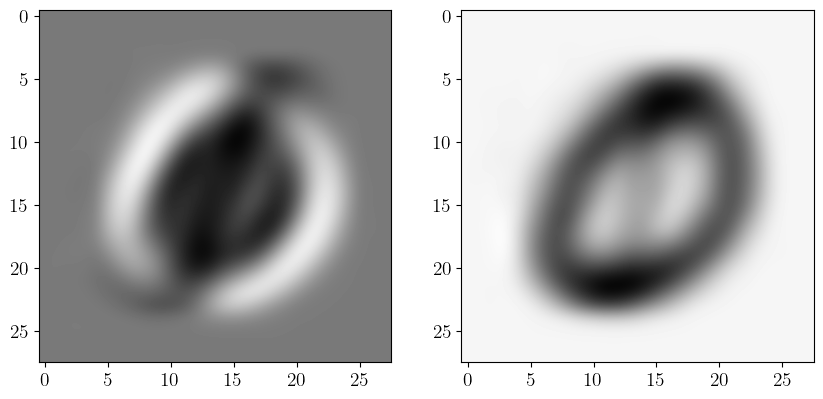

In [66]:
#cPCA with alpha = 1
k2_full_f = np.cov(X.T)
k2_full_b = np.cov(Y.T)
D,V=np.linalg.eig(k2_full_f-k2_full_b)
eig_idx = np.argpartition(D, -2)[-2:]
b_cpca=V[:,eig_idx]
full_size_pattern = b_cpca
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(patternimage_cICA(-full_size_pattern[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(full_size_pattern[:,1]), cmap="gray", interpolation="bicubic")

In [67]:
(np.sum(b_cpca[:,0]*normed_1.flatten()),np.sum(b_cpca[:,1]*normed_0.flatten())),(np.sum(b_cpca[:,0]*normed_0.flatten()),np.sum(b_cpca[:,1]*normed_1.flatten()))

((-0.14184337135827665, -0.6124042912049633),
 (0.4693996617294274, -0.9774232197988775))

In [68]:
(np.sum(b_cpca[:,0]*top_2[:,0]),np.sum(b_cpca[:,1]*top_2[:,1])),(np.sum(b_cpca[:,0]*top_2[:,1]),np.sum(b_cpca[:,1]*top_2[:,0]))

((0.7132470826975432, -0.8651004653889494),
 (-0.34023536044544833, -0.4905102249448666))

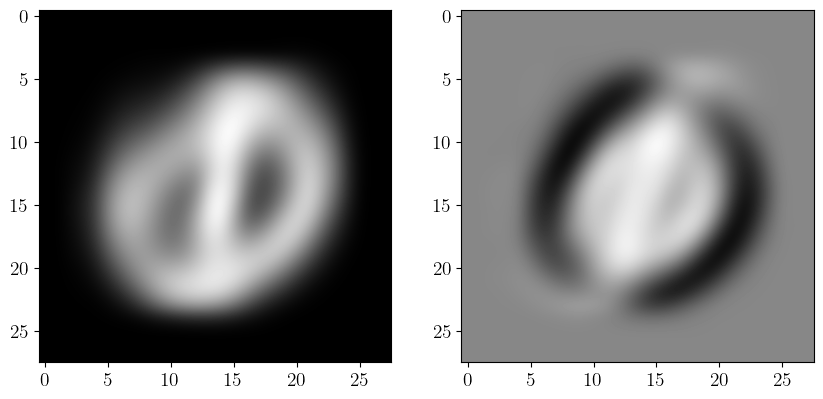

In [60]:
#PCPCA with gamma = 0.9
gamma = 0.9
n,m=X.shape[0],Y.shape[0]
pcpca = PCPCA(gamma=n/m*gamma, n_components=2)
pcpca.fit(X.T,Y.T)
b_pcpca=pcpca.W_mle/np.linalg.norm(pcpca.W_mle,axis=0,keepdims=True)
full_size_pattern = b_pcpca
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(patternimage_cICA(full_size_pattern[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(-full_size_pattern[:,1]), cmap="gray", interpolation="bicubic")

In [69]:
(np.sum(b_pcpca[:,0]*top_2[:,0]),np.sum(b_pcpca[:,1]*top_2[:,1])),(np.sum(b_pcpca[:,0]*top_2[:,1]),np.sum(b_pcpca[:,1]*top_2[:,0]))

((0.6185938117404827, 0.46248825883326905),
 (0.7356238978726019, -0.6691213614145892))

In [79]:
(np.sum(b_pcpca[:,0]*normed_1.flatten()),np.sum(b_pcpca[:,1]*normed_0.flatten())),(np.sum(b_pcpca[:,0]*normed_0.flatten()),np.sum(b_pcpca[:,1]*normed_1.flatten()))

((0.8992322624648525, -0.4195764235226601),
 (0.7302708123619144, 0.26833303813521925))

In [ ]:
#cICA

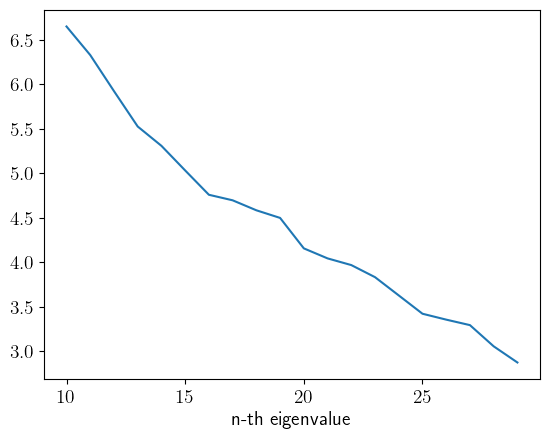

In [16]:
# choice of r= 18
I=k4_b.shape[0]
D,V=eig2(k4_b.reshape(I**2,I**2))
plt.figure()
plt.plot(range(10,30),abs(D)[10:30])
plt.xlabel('n-th eigenvalue')
tikzplotlib.save('digits_0136_r.tex')

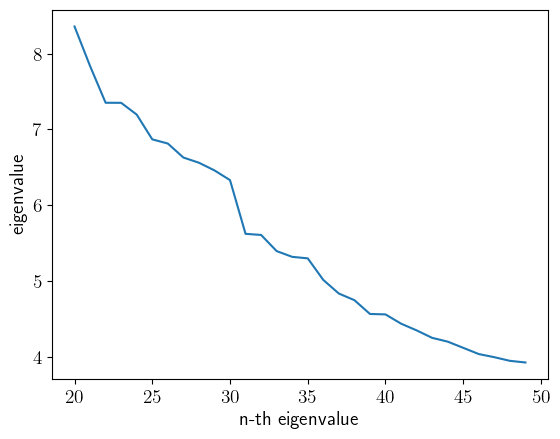

In [18]:
#cICA choices of r+\ell 34
I=k4_f.shape[0]
D,V=eig2(k4_f.reshape(I**2,I**2))
plt.plot(range(20,50),abs(D)[20:50])
plt.xlabel('n-th eigenvalue')
plt.ylabel('eigenvalue')
tikzplotlib.save('digits_0136_r_ell.tex')


In [30]:
def rank_background(a_s):
    back_var_list = []
    for a in a_s.T:
        back_var = (a.T@ k2_b @ a).flatten()
        back_var_list.append(back_var)
    ind=(-np.array(back_var_list)).flatten().argsort().tolist()
    return a_s[:,ind]

In [73]:
import keras
import random
from keras.datasets import mnist
np.random.seed(0)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
index_0=np.random.choice(list(np.where(y_train==0)[0]),10000,replace = True)
index_1=np.random.choice(list(np.where(y_train == 1)[0]),10000, replace = True)
index_3=np.random.choice(list(np.where(y_train == 3)[0]),20000, replace = True)
index_6=np.random.choice(list(np.where(y_train == 6)[0]),20000, replace = True)

strength = np.random.uniform(0,1,(6,10000))
foreground_3=np.zeros(shape = (10000,28*28))
background_3 = np.zeros(shape = (10000,28*28))
foreground_6 = np.zeros(shape = (10000,28*28))
background_6 = np.zeros(shape = (10000,28*28))
for i in range(10000):
    foreground_3_matrix = strength[2,i]*X_train[index_3[i]].T
    foreground_3[i,:] = foreground_3_matrix.reshape(1,-1)
    foreground_6_matrix = strength[3,i]*X_train[index_6[i]].T
    foreground_6[i,:] = foreground_6_matrix.reshape(1,-1)
    background_3_matrix = strength[4,i]*X_train[index_3[i+10000]].T
    background_3[i,:]= background_3_matrix.reshape(1,-1)
    background_6_matrix = strength[5,i]*X_train[index_6[i+10000]].T
    background_6[i,:]= background_6_matrix.reshape(1,-1)


foreground_3 = (foreground_3+np.random.normal(0,0.1,size = (20000,784))[:10000,:])/255
foreground_6 = (foreground_6+np.random.normal(0,0.1,size = (20000,784))[:10000,:])/255
background_6 = (background_6+np.random.normal(0,0.1,size = (20000,784))[10000:,:])/255
background_3 = (background_3+np.random.normal(0,0.1,size = (20000,784))[10000:,:])/255

foreground_3_scalar = foreground_3@ avarage_3.reshape(-1,1)/255
foreground_6_scalar = foreground_6@ avarage_6.reshape(-1,1)/255
background_3_scalar = background_3@ avarage_3.reshape(-1,1)/255
background_6_scalar = background_6@ avarage_6.reshape(-1,1)/255

from PyMoments import kstat

In [81]:
kstat(foreground_3_scalar,(0,0,0,0))/kstat(background_3_scalar,(0,0,0,0)),kstat(foreground_6_scalar,(0,0,0,0))/kstat(background_6_scalar,(0,0,0,0))

(0.33697732481052856, -0.7185205876497198)

-0.23171665966133564
[ 0.73499767  0.82406956 -3.8445134   1.32765343  0.43789943 -0.16771431
 -0.07001552  0.49462702 -6.81681457  0.04948031  0.4732044  -0.01585455
  0.68805769 -0.87986938  0.76047709  0.04588705  0.48819841 -0.87126922]


((-0.9391244344779266, 0.6205901571763046),
 (-0.21900622593525734, 0.4055285335027793))

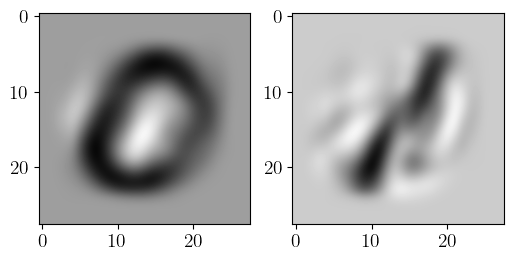

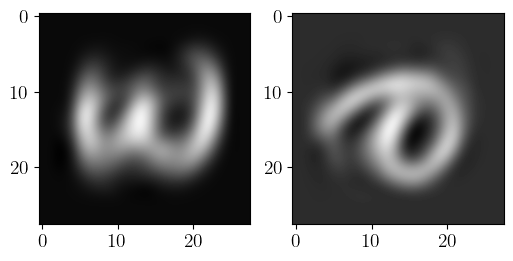

In [84]:
#cICA
np.random.seed(0)
a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground,lambda_prime,lambdas=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=1,r=18,l=16)
full_size_pattern = (b_s_sorted.T@pca.components_).T
fig,axes = plt.subplots(1,2,figsize=(6,3))
axes[0].imshow(patternimage_cICA(full_size_pattern[:,0]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(-full_size_pattern[:,1]), cmap="gray", interpolation="bicubic")
print(sum(full_size_pattern[:,0]*full_size_pattern[:,1]))

a_s_sorted = rank_background(a_s)
full_size_pattern = (a_s_sorted.T@pca.components_).T
fig,axes = plt.subplots(1,2,figsize=(6,3))
axes[0].imshow(patternimage_cICA(full_size_pattern[:,1]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(full_size_pattern[:,3]), cmap="gray", interpolation="bicubic")

my_array=lambda_prime/lambdas
back_var_list = []
for a in a_s.T:
    back_var = (a.T@ k2_b @ a).flatten()
    back_var_list.append(back_var)
ind=(-np.array(back_var_list)).flatten().argsort().tolist()
print(my_array[ind])

b= (b_s_sorted.T@pca.components_).T
(np.sum(b[:,0]*normed_1.flatten()),np.sum(b[:,1]*normed_0.flatten())),(np.sum(b[:,0]*normed_0.flatten()),np.sum(b[:,1]*normed_1.flatten()))

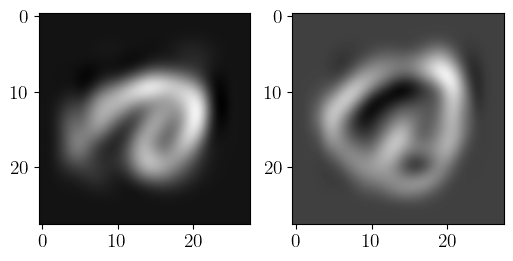

In [87]:
a_s_sorted = rank_background(a_s)
full_size_pattern = (a_s_sorted.T@pca.components_).T
fig,axes = plt.subplots(1,2,figsize=(6,3))
axes[0].imshow(patternimage_cICA(full_size_pattern[:,2]), cmap="gray", interpolation="bicubic")
axes[1].imshow(patternimage_cICA(full_size_pattern[:,8]), cmap="gray", interpolation="bicubic")

In [82]:
# compare the similarities between the patterns

#cICA vs cPCA
b_s_sorted_full = (b_s_sorted.T@pca.components_).T
print((np.sum(b_s_sorted_full[:,0]*b_cpca[:,0]),np.sum(b_s_sorted_full[:,1]*b_cpca[:,1])),(np.sum(b_s_sorted_full[:,0]*b_cpca[:,1]),np.sum(b_s_sorted_full[:,1]*b_cpca[:,0])))

#PCPCA vs cICA
print((np.sum(b_s_sorted_full[:,0]*b_pcpca[:,0]),np.sum(b_s_sorted_full[:,1]*b_pcpca[:,1])),(np.sum(b_s_sorted_full[:,0]*b_pcpca[:,1]),np.sum(b_s_sorted_full[:,1]*b_pcpca[:,0])))

# PCPCA vs cPCA
print((np.sum(b_cpca[:,0]*b_pcpca[:,0]),np.sum(b_cpca[:,1]*b_pcpca[:,1])),(np.sum(b_cpca[:,0]*b_pcpca[:,1]),np.sum(b_cpca[:,1]*b_pcpca[:,0])))


(0.2950118380293401, -0.49547500528268107) (0.8688691293569664, 0.47861267287028986)
(-0.7125029920579875, -0.4083827007167428) (-0.4192442611504246, 0.5540392513421972)
(0.1014261239130638, -0.12591126690766) (-0.9890568805696107, -0.9510374990145274)


# Interpretablity

# non-proportional setting

In [ ]:
# #cICA on synthetic data
np.random.seed()
for n in range(4,13):
    matrix=np.random.rand(n,n)
    Q,r=np.linalg.qr(matrix)
    # np.save(f'toy_example/Q_{n}_{n}',Q)
    B=Q[:,1:]
    A=np.random.randn(n,n)
    A=A/np.linalg.norm(A,axis=0)
    # np.save(f'toy_example/A_{n}_{n}',A)

    # Q=np.load(f'toy_example/Q_{n}_{n}.npy')
    # B=Q[:,1:]
    # A=np.load(f'toy_example/A_{n}_{n}.npy')
    scale=[2,1]*n
    scale_2=[1,2]*n
    n_samples=100000
    y=np.zeros((n-1,n_samples))
    scale_3=[2,1.5]*n
    for i in range(n-1):
        y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
    x_1=np.zeros((n,n_samples))
    x_2=np.zeros((n,n_samples))
    for i in range(n):
        x_1[i,:]=np.random.exponential(scale=scale[i],size=n_samples)
        x_2[i,:]=np.random.exponential(scale=scale_2[i],size=n_samples)
    X=A@x_2+B@y
    Y=A@x_1
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    # np.save(f'toy_example/X_{n}',X)
    # np.save(f'toy_example/Y_{n}',Y)
    cosine_list=[]
    rel_frob_list=[]
    for i in range(100):
            a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=30,r=n,l=n-1)
            cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
            cosine_list.append(cosine_sim_list)
            rel_frob_list.append(relfroberror)
    # np.save(f'toy_example/cosine_list_{n}',np.array(cosine_list))
    # np.save(f'toy_example/rel_frob_list_{n}',np.array(rel_frob_list))

In [ ]:
for n in range(4,13):
    X=np.load(f'toy_example/X_{n}.npy')
    Y=np.load(f'toy_example/Y_{n}.npy')
    # k2_f,k4_f=cumulant_tensors(X.T)
    # k2_b,k4_b=cumulant_tensors(Y.T)
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    pcpca_cosine_list=[]
    pcpca_rel_frob_list=[]
#     likelihood=[]
    for i,gamma in enumerate(np.linspace(0,0.9,100)):
            pcpca = PCPCA(gamma=gamma, n_components=n-1)
            pcpca.fit(X,Y)
            pcpca_B=pcpca.W_mle
            pcpca_B=pcpca_B/np.linalg.norm(pcpca_B,axis=0)
            cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(pcpca_B,B)
            pcpca_cosine_list.append(cosine_sim_list)
            pcpca_rel_frob_list.append(relfroberror)
        #     likelihood.append(log_likelihood_fg(X,pcpca.W_mle,pcpca.sigma2_mle))    
    np.save(f'toy_example/pcpca_cosine_list_{n}',np.array(pcpca_cosine_list))
    np.save(f'toy_example/pcpca_rel_frob_list_{n}',np.array(pcpca_rel_frob_list))
#     np.save(f'toy_example/likelihood_{n}',np.array(likelihood))

In [ ]:
for n in range(4,13):
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    X=np.load(f'toy_example/X_{n}.npy')
    Y=np.load(f'toy_example/Y_{n}.npy')
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)


    CPCA_cosine_list=[]
    CPCA_rel_frob_list=[]
    alphas=np.logspace(-4,4,num=100)
    for alpha in alphas:
        D,V=eig2(k2_f-alpha*k2_b)
        b_cpca=V[:,:n-1]
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_cpca,B)
        CPCA_cosine_list.append(cosine_sim_list)
        CPCA_rel_frob_list.append(relfroberror)
    # np.save(f'toy_example/CPCA_cosine_list_{n}',np.array(CPCA_cosine_list))
    # np.save(f'toy_example/CPCA_rel_frob_list_{n}',np.array(CPCA_rel_frob_list))
    HTD_cosine_list=[]
    HTD_rel_frob_list=[]
    for alpha in alphas: 
        gamma=np.sqrt(alpha)
        b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,n-1)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        HTD_cosine_list.append(cosine_sim_list)
        HTD_rel_frob_list.append(relfroberror)
    # np.save(f'toy_example/HTD_cosine_list_{n}',np.array(HTD_cosine_list))
    # np.save(f'toy_example/HTD_rel_frob_list_{n}',np.array(HTD_rel_frob_list))

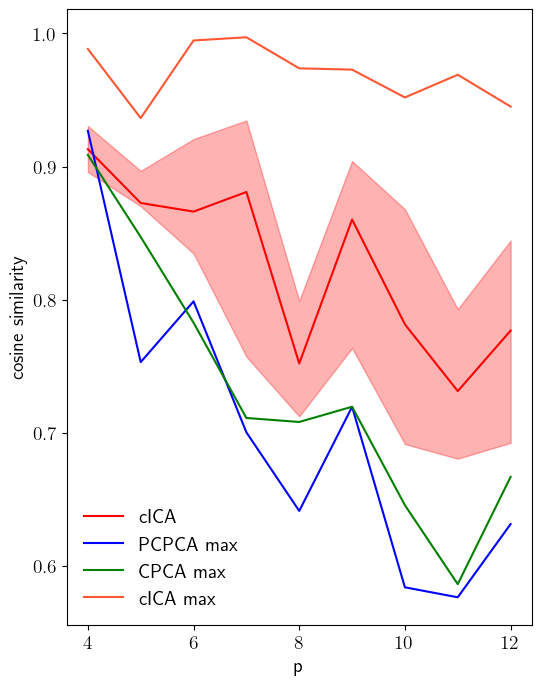

In [48]:
CICA_75=[]
CICA_median=[]
CICA_25=[]
CICA_max=[]
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
HTD_75=[]   
HTD_median=[]
HTD_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_max=[]
CPCA_max=[]
HTD_max=[]
for n in range(4,13):
    a=np.mean(np.load(f'toy_example/pcpca_cosine_list_{n}.npy'),axis=1)
    b=np.mean(np.load(f'toy_example/cosine_list_{n}.npy'),axis=1)
    c=np.mean(np.load(f'toy_example/CPCA_cosine_list_{n}.npy'),axis=1)
    d=np.mean(np.load(f'toy_example/HTD_cosine_list_{n}.npy'),axis=1)
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_max.append(np.max(a))

    CICA_75.append(np.quantile(b,0.75))
    CICA_median.append(np.median(b))
    CICA_25.append(np.quantile(b,0.25))
    CICA_max.append(np.max(b))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_max.append(np.max(c))

    HTD_75.append(np.quantile(d,0.75))
    HTD_median.append(np.median(d))
    HTD_25.append(np.quantile(d,0.25))
    HTD_max.append(np.max(d))
fix,ax=plt.subplots(1,1,figsize=(6,8))
ax.plot(range(4,13),CICA_median,label='cICA',color='red')
ax.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

ax.plot(range(4,13),PCPCA_max,label='PCPCA max',color='blue')

ax.plot(range(4,13),CPCA_max,label='CPCA max',color='green')

ax.plot(range(4,13),CICA_max,label='cICA max',color='#FF5733')

ax.set_xlabel('p')
ax.set_ylabel('cosine similarity')
ax.legend(frameon=False)

tikzplotlib_fix_ncols(fix)

tikzplotlib.save("cosine_similarity_general.tex")

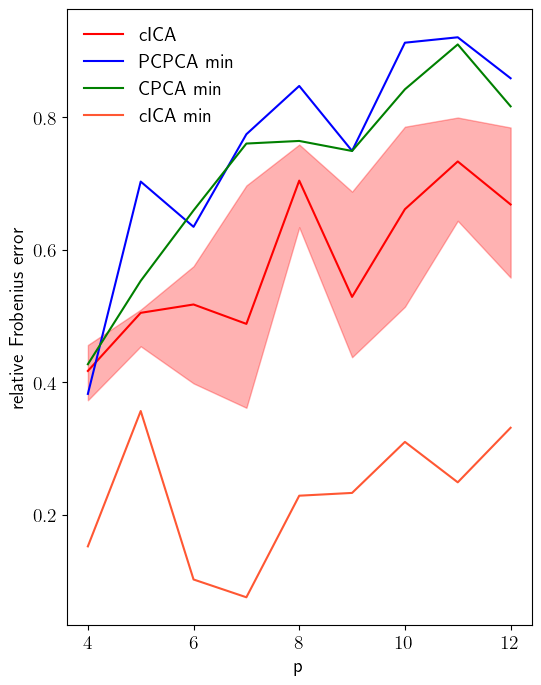

In [49]:
CICA_75=[]
CICA_median=[]
CICA_25=[]
CICA_min=[]
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
HTD_75=[]   
HTD_median=[]
HTD_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_min=[]
CPCA_min=[]
HTD_min=[]
for n in range(4,13):
    a=np.load(f'toy_example/pcpca_rel_frob_list_{n}.npy')
    b=np.load(f'toy_example/rel_frob_list_{n}.npy')
    c=np.load(f'toy_example/CPCA_rel_frob_list_{n}.npy')
    d=np.load(f'toy_example/HTD_rel_frob_list_{n}.npy')
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_min.append(np.min(a))

    CICA_75.append(np.quantile(b,0.75))
    CICA_median.append(np.median(b))
    CICA_25.append(np.quantile(b,0.25))
    CICA_min.append(np.min(b))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_min.append(np.min(c))

    HTD_75.append(np.quantile(d,0.75))
    HTD_median.append(np.median(d))
    HTD_25.append(np.quantile(d,0.25))
    HTD_min.append(np.min(d))

fix,ax=plt.subplots(1,1,figsize=(6,8))
ax.plot(range(4,13),CICA_median,label='cICA',color='red')
ax.fill_between(range(4,13), CICA_25, CICA_75, color='red', alpha=0.3)

ax.plot(range(4,13),PCPCA_min,label='PCPCA min',color='blue')

ax.plot(range(4,13),CPCA_min,label='CPCA min',color='green')

ax.plot(range(4,13),CICA_min,label='cICA min',color='#FF5733')

ax.set_xlabel('p')
ax.set_ylabel('relative Frobenius error')
ax.legend(frameon=False)
tikzplotlib_fix_ncols(fix)

tikzplotlib.save("rel_frob_general.tex")

# proportional setting

In [ ]:
best_gamma=[]
for n in range(4,13):
    Q=np.load(f'toy_example/Q_{n}_{n}.npy')
    B=Q[:,1:]
    A=np.load(f'toy_example/A_{n}_{n}.npy')
    n_samples=100000
    np.random.seed(0)
    y=np.zeros((n-1,n_samples))
    scale_3=[2,1.5]*n
    for i in range(n-1):
        y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
    x_1=np.random.exponential(2,size=(n,n_samples))
    x_2=np.random.exponential(2,size=(n,n_samples))
    X=A@x_2+B@y
    Y=A@x_1
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    np.save(f'toy_example_2/X_{n}',X)
    np.save(f'toy_example_2/Y_{n}',Y)

    CPCA_cosine_list=[]
    CPCA_rel_frob_list=[]
    alphas=np.logspace(-4,4,num=100)
    for alpha in alphas:
        D,V=eig2(k2_f-alpha*k2_b)
        b_cpca=V[:,:n-1]
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_cpca,B)
        CPCA_cosine_list.append(cosine_sim_list)
        CPCA_rel_frob_list.append(relfroberror)
    np.save(f'toy_example_2/CPCA_cosine_list_{n}',np.array(CPCA_cosine_list))
    np.save(f'toy_example_2/CPCA_rel_frob_list_{n}',np.array(CPCA_rel_frob_list))
    HTD_cosine_list=[]
    HTD_rel_frob_list=[]
    for alpha in alphas: 
        gamma=np.sqrt(alpha)
        b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,n-1)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        HTD_cosine_list.append(cosine_sim_list)
        HTD_rel_frob_list.append(relfroberror)
    cosine_array=np.array(HTD_cosine_list)
    index=np.argmax(np.mean(cosine_array,axis=1))
    best_gamma.append(np.sqrt(alphas)[index])
    np.save(f'toy_example_2/HTD_cosine_list_{n}',np.array(HTD_cosine_list))
    np.save(f'toy_example_2/HTD_rel_frob_list_{n}',np.array(HTD_rel_frob_list))

In [ ]:
X=np.load(f'toy_example_2/X_{n}.npy')
Y=np.load(f'toy_example_2/Y_{n}.npy')
k2_f,k4_f=cumulant_tensors(X.T)
k2_b,k4_b=cumulant_tensors(Y.T)

In [ ]:
gamma_list=[]
for n in range(4,13):
    X=np.load(f'toy_example_2/X_{n}.npy')
    Y=np.load(f'toy_example_2/Y_{n}.npy')
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    I=k4_b.shape[0]
    a_s,lambdas=subspace_power_method(k4_b,n=4,d=n,r=n)
    def returnmindistancebewteenvectors(cols):
        def distancebewteenvectors(v1,v2):
            v1=v1.reshape(-1,1)
            v2=v2.reshape(-1,1)
            M=v1@np.transpose(v1)-v2@np.transpose(v2)
            return np.sum(M*M)
        lens=cols.shape[1]
        error=1
        for i in range(lens):
            for j in range(i+1,lens):
                error=min(error,max(distancebewteenvectors(cols[:,i],cols[:,j]),distancebewteenvectors(cols[:,i],-cols[:,j])))
        return error
    step=0
    step_max=100
    while returnmindistancebewteenvectors(a_s)<0.1 and step<step_max:
        a_s,lambdas=subspace_power_method(k4_b,n=4,d=n,r=n)
        step+=1
    k4_f_copy=k4_f.copy()
    matK4f=k4_f_copy.reshape(I**2,I**2)
    symind, findsym, symindscale = symmetric_indices(I, 2)
    symindscale = np.sqrt(symindscale)
    findsym = findsym.flatten()
    symind = symind[::-1,:].T @ (I ** np.arange(2))
    sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
    D, symV = eig2(sym_matK4f)
    eigtol= 1e-12
    rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
    D = D[:rank_k4_f]
    V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
    D1 = np.diagflat(1. / D).T
    # learn coefficients of a_i in k4_f
    lambda_prime=[]
    for a in a_s.T:
        apow = khatri_rao_power(a.reshape(-1, 1), 2)
        alpha = (apow.T @ V).T
        D1alpha = D1 @ alpha
        scalar=(alpha.T @ D1alpha)[0,0]
        k4_f_copy-=(1. / scalar)*generate_lowrank_tensor(a.reshape(-1,1),4)
        lambda_prime.append(1./scalar)
        matK4f=k4_f_copy.reshape(I**2,I**2)
        sym_matK4f = symindscale.reshape(1, -1) * matK4f[symind][:, symind] * symindscale.reshape(-1, 1)
        D, symV = eig2(sym_matK4f)
        eigtol= 1e-12
        rank_k4_f=D.shape[0] - np.searchsorted(abs(D[::-1]), eigtol)
        D = D[:rank_k4_f]
        V = (symV[:, :rank_k4_f] / symindscale.reshape(-1, 1))[findsym, :]
        D1 = np.diagflat(1. / D).T
    lamdas=np.array(lambdas)
    lambda_prime=np.array(lambda_prime)
    gamma_list.append(np.product(lambda_prime**(1/n))/np.product(lambdas**(1/n)))
    print(n,np.product(lambda_prime**(1/n))/np.product(lambdas**(1/n)))


In [66]:
np.save('toy_example_2/gamma_list_computed_via_thm',gamma_list)
gamma_list

array([1.07443516, 1.01543858, 1.01750544, 1.06566841, 0.94774252,
       0.95222673, 1.04673448, 1.00977242, 1.01859887])

In [59]:
HTD_cosine_list=[]
HTD_rel_frob_list=[]
for n in [7,10]:
    print(n)
    X=np.load(f'toy_example_2/X_{n}.npy')
    Y=np.load(f'toy_example_2/Y_{n}.npy')
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    index=n-4
    gamma=gamma_list[index]
    b_s_sorted,coeff=HTD(k4_b,k4_f,k2_b,k2_f,gamma,n-1)
    cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
    
    HTD_cosine_list.append(np.mean(cosine_sim_list))
    HTD_rel_frob_list.append(relfroberror)

np.save('toy_example_2/HTD_cosine_list',np.array(HTD_cosine_list))
np.save('toy_example_2/HTD_rel_frob_list',np.array(HTD_rel_frob_list))


In [ ]:
for n in range(4,13):
    X=np.load(f'toy_example_2/X_{n}.npy')
    Y=np.load(f'toy_example_2/Y_{n}.npy')
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    B=np.load(f'toy_example/Q_{n}_{n}.npy')[:,1:]
    pcpca_cosine_list=[]
    pcpca_rel_frob_list=[]
    likelihood=[]
    for i,gamma in enumerate(np.linspace(0,0.9,100)):
            pcpca = PCPCA(gamma=gamma, n_components=n-1)
            pcpca.fit(X,Y)
            pcpca_B=pcpca.W_mle
            pcpca_B=pcpca_B/np.linalg.norm(pcpca_B,axis=0)
            cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(pcpca_B,B)
            pcpca_cosine_list.append(cosine_sim_list)
            pcpca_rel_frob_list.append(relfroberror)  
    np.save(f'toy_example_2/pcpca_cosine_list_{n}',np.array(pcpca_cosine_list))
    np.save(f'toy_example_2/pcpca_rel_frob_list_{n}',np.array(pcpca_rel_frob_list))

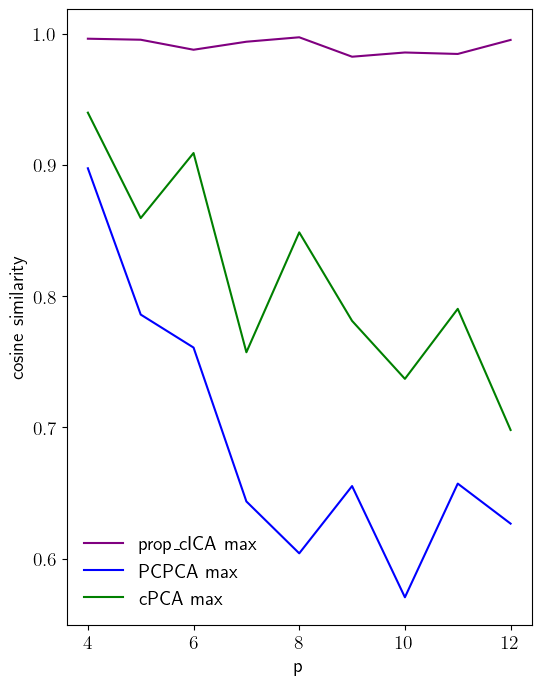

In [50]:
CICA_75=[]
CICA_median=[]
CICA_25=[]
CICA_max=[]
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_max=[]
CPCA_max=[]
# HTD_max=[]
for n in range(4,13):
    a=np.mean(np.load(f'toy_example_2/pcpca_cosine_list_{n}.npy'),axis=1)
    c=np.mean(np.load(f'toy_example_2/CPCA_cosine_list_{n}.npy'),axis=1)
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_max.append(np.max(a))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_max.append(np.max(c))
HTD_cosine_list=np.load('toy_example_2/HTD_cosine_list.npy')
HTD_rel_frob_list=np.load('toy_example_2/HTD_rel_frob_list.npy')
fix,ax=plt.subplots(1,1,figsize=(6,8))
ax.plot(range(4,13),HTD_cosine_list,label='prop_cICA max',color='purple')

ax.plot(range(4,13),PCPCA_max,label='PCPCA max',color='blue')

ax.plot(range(4,13),CPCA_max,label='cPCA max',color='green')

ax.set_xlabel('p')
ax.set_ylabel('cosine similarity')
ax.legend(frameon=False)

tikzplotlib_fix_ncols(fix)

tikzplotlib.save("cosine_similarity_proportional.tex")

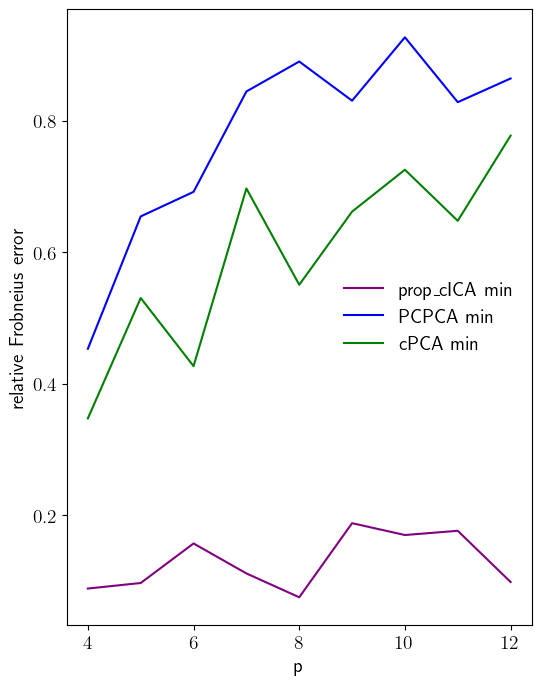

In [52]:
CPCA_75=[]
CPCA_median=[]
CPCA_25=[]
HTD_75=[]   
HTD_median=[]
HTD_25=[]
PCPCA_75=[]
PCPCA_median=[]
PCPCA_25=[]
PCPCA_min=[]
CPCA_min=[]
HTD_rel_frob_list=np.load('toy_example_2/HTD_rel_frob_list.npy')
for n in range(4,13):
    a=np.load(f'toy_example_2/pcpca_rel_frob_list_{n}.npy')
    c=np.load(f'toy_example_2/CPCA_rel_frob_list_{n}.npy')
    PCPCA_75.append(np.quantile(a,0.75))
    PCPCA_median.append(np.median(a))
    PCPCA_25.append(np.quantile(a,0.25))
    PCPCA_min.append(np.min(a))

    CPCA_75.append(np.quantile(c,0.75))
    CPCA_median.append(np.median(c))
    CPCA_25.append(np.quantile(c,0.25))
    CPCA_min.append(np.min(c))

fix,ax=plt.subplots(1,1,figsize=(6,8))

ax.plot(range(4,13),HTD_rel_frob_list,label='prop_cICA min',color='purple')
ax.plot(range(4,13),PCPCA_min,label='PCPCA min',color='blue')

ax.plot(range(4,13),CPCA_min,label='cPCA min',color='green')

ax.set_xlabel('p')
ax.set_ylabel('relative Frobneius error')
ax.legend(frameon=False)

tikzplotlib_fix_ncols(fix)

tikzplotlib.save("rel_frob_proportional.tex")


In [99]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rcParams['text.usetex'] = True

# testing for nonlinearity

In [24]:
n=4
Q=np.load(f'toy_example/Q_{n}_{n}.npy')
B=Q[:,0:2]
A=Q[:,2:]
n_samples=1000000


def transform_columns(matrix):
    # Get the number of columns
    num_cols = matrix.shape[1]
    
    # Initialize an empty list to store the transformed columns
    transformed_columns = []
    
    # Iterate over each column
    for i in range(num_cols):
        x, y = matrix[:, i]
        transformed_column = [x**3, x**2 * y, x * y**2, y**3]
        transformed_columns.append(transformed_column)
    
    # Convert the list of transformed columns to a numpy array
    transformed_matrix = np.array(transformed_columns).T
    
    return transformed_matrix


y=np.zeros((n-2,n_samples))
scale_3=[2,1.5]*n
for i in range(n-2):
    y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
x_1=np.random.exponential(2,size=(2,n_samples))
x_2=np.random.exponential(2,size=(2,n_samples))
alphas=[0,0.0001,0.001,0.01,0.1,1]


lambda_squared_list=np.logspace(-4,4,num=100)


#nonlinear perturbation on foreground 
cosine_mean_list_background=[]
rel_frob_list_mean_background=[]

np.random.seed()
for alpha in alphas:
    X=A@x_2+B@y+alpha*transform_columns(x_2)
    Y=A@x_1+alpha*transform_columns(x_1)
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    cosine_list=[]
    rel_frob_list=[]
    for i in range(100):
        a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=30,r=2,l=2)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        cosine_list.append(cosine_sim_list)
        rel_frob_list.append(relfroberror)
    cosine_mean_list_background.append(np.mean(cosine_sim_list))
    rel_frob_list_mean_background.append(np.mean(relfroberror))


    

In [25]:
rel_frob_list_mean_background

[0.0035540737943818694,
 0.003455961642550066,
 0.025876078682886525,
 0.6679156608269874,
 1.2498182392544854,
 1.249735754035943]

In [7]:
n=4
Q=np.load(f'toy_example/Q_{n}_{n}.npy')
B=Q[:,0:2]
A=Q[:,2:]
n_samples=1000000


def transform_columns(matrix):
    # Get the number of columns
    num_cols = matrix.shape[1]
    
    # Initialize an empty list to store the transformed columns
    transformed_columns = []
    
    # Iterate over each column
    for i in range(num_cols):
        x, y = matrix[:, i]
        transformed_column = [x**3, x**2 * y, x * y**2, y**3]
        transformed_columns.append(transformed_column)
    
    # Convert the list of transformed columns to a numpy array
    transformed_matrix = np.array(transformed_columns).T
    
    return transformed_matrix

np.random.seed(0)
y=np.zeros((n-2,n_samples))
scale_3=[2,1.5]*n
for i in range(n-2):
    y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
x_1=np.random.exponential(2,size=(2,n_samples))
x_2=np.random.exponential(2,size=(2,n_samples))
alphas=[0,0.0001,0.001,0.01,0.1,1]


lambda_squared_list=np.logspace(-4,4,num=100)


#nonlinear perturbation on foreground 
cosine_mean_list_foreground=[]
rel_frob_list_mean_foreground=[]

np.random.seed()
for alpha in alphas:
    X=A@x_2+B@y+alpha*transform_columns(y)
    Y=A@x_1
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    cosine_list=[]
    rel_frob_list=[]
    for i in range(100):
        a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=30,r=2,l=2)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        cosine_list.append(cosine_sim_list)
        rel_frob_list.append(relfroberror)
    cosine_mean_list_foreground.append(np.mean(cosine_sim_list))
    rel_frob_list_mean_foreground.append(np.mean(relfroberror))


In [12]:
n=4
Q=np.load(f'toy_example/Q_{n}_{n}.npy')
B=Q[:,0:2]
A=Q[:,2:]
n_samples=1000000


def transform_columns(matrix):
    # Get the number of columns
    num_cols = matrix.shape[1]
    
    # Initialize an empty list to store the transformed columns
    transformed_columns = []
    
    # Iterate over each column
    for i in range(num_cols):
        x, y = matrix[:, i]
        transformed_column = [x**3, x**2 * y, x * y**2, y**3]
        transformed_columns.append(transformed_column)
    
    # Convert the list of transformed columns to a numpy array
    transformed_matrix = np.array(transformed_columns).T
    
    return transformed_matrix


y=np.zeros((n-2,n_samples))
scale_3=[2,1.5]*n
for i in range(n-2):
    y[i,:]=np.random.exponential(scale_3[i],size=n_samples)
x_1=np.random.exponential(2,size=(2,n_samples))
x_2=np.random.exponential(2,size=(2,n_samples))
alphas=[0,0.0001,0.001,0.01,0.1,1]


lambda_squared_list=np.logspace(-4,4,num=100)


#nonlinear perturbation on foreground 
cosine_mean_list_both=[]
rel_frob_list_mean_both=[]

np.random.seed()

for alpha in alphas:
    X=A@x_2+B@y+alpha*transform_columns(y)+alpha*transform_columns(x_2)
    Y=A@x_1+alpha*transform_columns(x_1)
    k2_f,k4_f=cumulant_tensors(X.T)
    k2_b,k4_b=cumulant_tensors(Y.T)
    cosine_list=[]
    rel_frob_list=[]
    for i in range(50):
        a_s,b_s_sorted,coeff,first_residual,second_residual,D_foreground=recover_pattern_tensor_eigen(k4_b,k4_f,k2_f,k2_b,step_max=30,r=2,l=2)
        cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(b_s_sorted,B)
        cosine_list.append(cosine_sim_list)
        rel_frob_list.append(relfroberror)
    cosine_mean_list_both.append(np.mean(cosine_sim_list))
    rel_frob_list_mean_both.append(np.mean(relfroberror))


In [20]:
rel_frob_list_mean_both

[0.003425993864940568,
 0.01889838883703909,
 0.18548500510622482,
 1.2531992132898877,
 1.258805164069522,
 1.264660075950158]

Text(0.5, 1.0, 'nonlinearity in background, foreground and both')

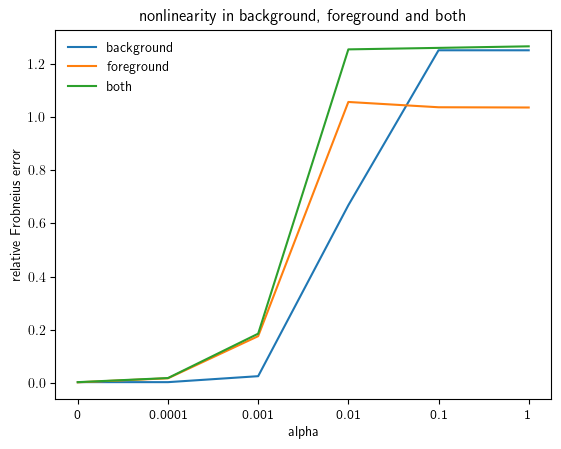

In [26]:
fix,ax=plt.subplots(1,1)
ax.plot(range(1,7),rel_frob_list_mean_background,label='background')
ax.plot(range(1,7),rel_frob_list_mean_foreground,label='foreground')
ax.plot(range(1,7),rel_frob_list_mean_both,label='both')

ax.set_xlabel('alpha')
ax.set_ylabel('relative Frobneius error')
ax.legend(frameon=False)
ax.set_xticks(range(1,7))
ax.set_xticklabels(alphas)
ax.set_title("nonlinearity in background, foreground and both")

In [27]:
np.save('nonlinear/rel_frob_list_mean_background',rel_frob_list_mean_background)
np.save('nonlinear/rel_frob_list_mean_foreground',rel_frob_list_mean_foreground)
np.save('nonlinear/rel_frob_list_mean_both',rel_frob_list_mean_both)

# degree 2 nonlinear transformation

In [2]:
import numpy as np

# Generate a random 3 by 3 matrix
matrix = np.random.rand(3, 3)

# Make the rows orthogonal
orthogonal_matrix = np.linalg.qr(matrix)[0]


def rescale_rows_to_product_one(matrix):
    rescaled_matrix = np.copy(matrix)
    for i in range(rescaled_matrix.shape[0]):
        row_product = np.prod(rescaled_matrix[i, :])
        print(row_product)
        if row_product != 0:
            scale=abs(row_product)**(1/3)
            scaling_factor = 1/scale*np.sign(row_product)
            rescaled_matrix[i, :] *= scaling_factor
    return rescaled_matrix


A=rescale_rows_to_product_one(orthogonal_matrix)


-0.005873127973797396
-0.01555002674002248
0.022677918118682118


In [3]:
A

array([[ 0.45775577, -5.50937127, -0.39651912],
       [ 3.8546235 ,  0.24362888,  1.06485205],
       [-0.91800759, -0.32072234,  3.39644446]])

In [4]:
np.random.seed(0)
s=np.random.multivariate_normal(np.zeros(3), np.identity(3), size=1000000)

def transform_columns_deg2(matrix):
    # Get the number of columns
    num_cols = matrix.shape[0]
    
    # Initialize an empty list to store the transformed columns
    transformed_columns = []
    
    # Iterate over each column
    for i in range(num_cols):
        x, y ,z = matrix[i,:]
        transformed_column = [x*y,x*z,y*z]
        transformed_columns.append(transformed_column)
    
    # Convert the list of transformed columns to a numpy array
    transformed_matrix = np.array(transformed_columns).T
    
    return transformed_matrix

x=A @ transform_columns_deg2(s)

In [8]:
from PyMoments import kstat
from itertools import product

def cumulant_tensors_3(observeddata):
    I=observeddata.shape[1]
    sym_indices,b,c=symmetric_indices(I,3)
    fourth_cumulants=np.apply_along_axis(lambda x: kstat(observeddata,tuple(x)), 0, sym_indices)
    fourth_cumulant_dict={tuple(sym_indices[:,n]):fourth_cumulants[n] for n in range(len(fourth_cumulants))}
    all_indices=np.array([list(i) for i in product(range(I), range(I),range(I))])
    values=np.apply_along_axis(lambda x:fourth_cumulant_dict[tuple(np.sort(x))],1,all_indices)
    third_order_kstats=values.reshape(I,I,I)
    return third_order_kstats

k3=cumulant_tensors_3(x.T)

In [18]:
A_1=np.array([[0,A[0,0],A[0,1]],[A[0,0],0,A[0,2]],[A[0,1],A[0,2],0]])
A_2=np.array([[0,A[1,0],A[1,1]],[A[1,0],0,A[1,2]],[A[1,1],A[1,2],0]])
A_3=np.array([[0,A[2,0],A[2,1]],[A[2,0],0,A[2,2]],[A[2,1],A[2,2],0]])
np.trace(A_2@A_2@A_3)

3.269994363698303

In [9]:
k3

array([[[  5.70366548,  12.64294191, -21.39154742],
        [ 12.64294191, -44.92880499, -65.74841973],
        [-21.39154742, -65.74841973,  33.68759865]],

       [[ 12.64294191, -44.92880499, -65.74841973],
        [-44.92880499,   6.12910352,   3.45677489],
        [-65.74841973,   3.45677489,  -8.93110162]],

       [[-21.39154742, -65.74841973,  33.68759865],
        [-65.74841973,   3.45677489,  -8.93110162],
        [ 33.68759865,  -8.93110162,   6.36180954]]])

In [21]:
A.T

array([[ 0.45775577,  3.8546235 , -0.91800759],
       [-5.50937127,  0.24362888, -0.32072234],
       [-0.39651912,  1.06485205,  3.39644446]])

In [25]:
recovered_matrix=  np.array([[0.440859,  4.06666,   -1.09887],
 [-5.52842,   0.254718,  -0.308378],
[ -0.390033,  0.986164,   3.12896]])

cosine_sim_list,mean_cosine_list,relfroberror,froberror=similarity_measures_withpermutation(recovered_matrix, A.T)
relfroberror

0.22830988415744644

In [32]:
np.save('nonlinear/recovered_A.npy',recovered_matrix)